# Starbucks Capstone Challenge

## 1. Problem Definition

#### Description of Data

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Not all users receive the same offer and some users might not receive any offer during certain weeks.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

There are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. Someone using the app might make a purchase through the app without having received an offer or seen an offer. For example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer. However, a user can receive an offer, never actually view the offer, and still complete the offer (so the customer was not influenced by the offer because the customer never viewed the offer).

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed


#### Problem definition

I will combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. 


## 2. Data Analysis

#### Importing packages


In [905]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import seaborn as sns

#### Data Gathering

In [906]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Data Exploration and Visualization


**Portfolio dataset**

In [907]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [908]:
#check how many offers exist
print(portfolio.shape[0]) # --> 10 offers

10


In [909]:
#check if there are any nan values included in this dataset 
print(portfolio.isna().any()) # --> no nan values

reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool


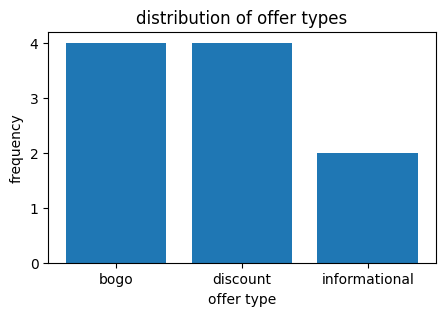

In [910]:
#show the distribution of offer types
offer_type_distribution = portfolio.groupby(['offer_type']).count().reset_index()[['offer_type',"id"]]

def create_bar_chart(x_values,y_values,x_label,y_label,title):
    plt.bar(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

plt.figure(figsize=(5, 3))
create_bar_chart(offer_type_distribution['offer_type'],offer_type_distribution['id'],'offer type','frequency','distribution of offer types')



There are 4 bogo offers, 4 discount offers and 2 informational offers. 

**Profile dataset**

In [911]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [912]:
#check if the user id column has duplicates 
print(profile['id'].duplicated().any()) # --> False (no duplicates)

False


In [913]:
#check how many customers the dataset includes 
print(profile.shape[0]) # --> 17000 customers (because we have no duplicated user ids)

17000


In [914]:
#check which columns include nan values
print(profile.isna().any()) #columns "gender" and "income" have nan values --> to be solved in the Data Cleaning part

gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool


          gender    id
0              F  6129
1              M  8484
2              O   212
0  not specified  2175
0    0.360529
1    0.499059
2    0.012471
0    0.127941
Name: id, dtype: float64


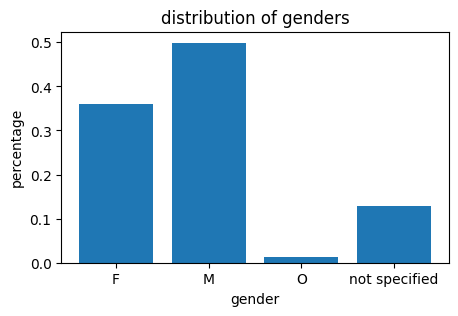

In [915]:
#show the distribution of genders
gender_distribution = profile.groupby(['gender']).count().reset_index()[['gender',"id"]] 
new_row = pd.DataFrame({'gender': ["not specified"],"id": [profile["gender"].isna().sum()]})
gender_distribution = pd.concat([gender_distribution,new_row])
print(gender_distribution)
print()
print(gender_distribution['id']/gender_distribution['id'].sum())

#create a bar chart
plt.figure(figsize=(5, 3))
create_bar_chart(gender_distribution['gender'],gender_distribution['id']/gender_distribution['id'].sum(),'gender','percentage','distribution of genders')



The graph show that there are 50% male, 36% female and 1% other genders. Furthermore, 13% did not give any information about gender.

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


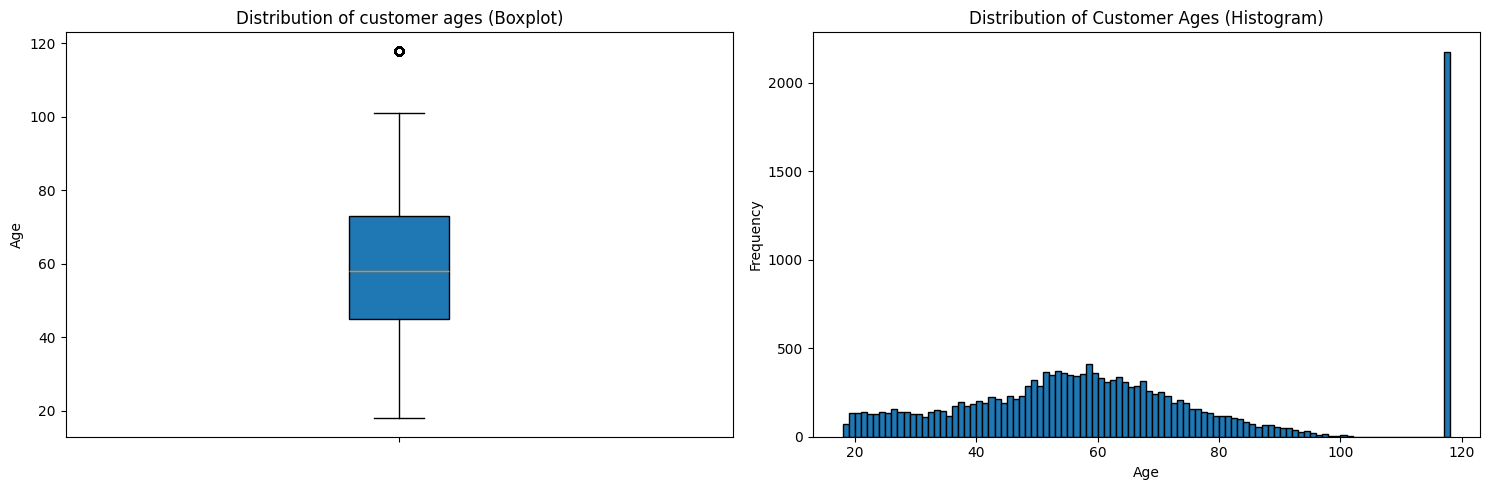

84    2175
Name: count, dtype: int64


In [916]:
#show the distribution of ages
print(profile["age"].describe())

def create_boxplot(values,title,x_ticks,x_label,y_ticks,y_label):
    plt.boxplot(values, patch_artist=True)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(x_ticks, x_label)

def create_histogram(values,bins,title,x_label,y_label):
    plt.hist(values, bins, edgecolor='black')  
    plt.title(title)  
    plt.xlabel(x_label)
    plt.ylabel(y_label)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
create_boxplot(profile['age'],'Distribution of customer ages (Boxplot)',[1],[''],[6],'Age')
plt.subplot(1, 2, 2)
create_histogram(profile['age'], max(profile['age'])-min(profile['age']),'Distribution of Customer Ages (Histogram)','Age','Frequency')
plt.tight_layout()
plt.show()

#check how many data points the outlier 118 years has
distribution_of_ages = profile.groupby('age').size().reset_index(name='count')
print(distribution_of_ages[distribution_of_ages['age'] == 118]['count'])

There ia a range of 18 years to 118 years. The mean age is 62 years.
The graphics above show that there is an outlier in the data (118 years). As only very few people can get this old, the outlier should be looked at in more detail. As there are over 2000 user ids with age of 118 and the difference to the last age before that (101) is quite high, I suppose that 118 is not the real age of these users. Probably this is a default value for those users who did not give information about their age. Furthermore, it is the same number of "missing values" as in the gender column (2175). I will further address this issue in the data cleaning section below (chapter 3).

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


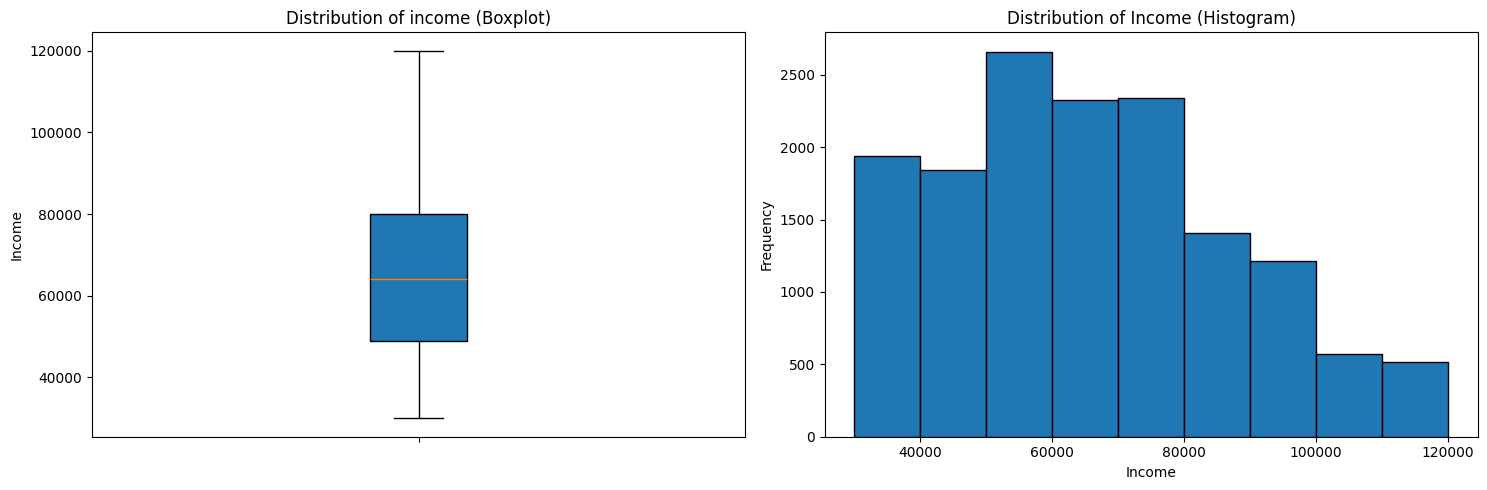

84    2175
Name: count, dtype: int64


In [917]:
#show the distribution of income
print(profile["income"].describe())

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
create_boxplot(profile.dropna()['income'],'Distribution of income (Boxplot)',[1],[''],np.arange(30000, 130000, 10000),"Income")
plt.subplot(1, 2, 2)
create_histogram(profile['income'], int((120000-30000)/10000),'Distribution of Income (Histogram)','Income','Frequency')
plt.tight_layout()
plt.show()

#check how many data points the outlier 118 years has
distribution_of_ages = profile.groupby('age').size().reset_index(name='count')
print(distribution_of_ages[distribution_of_ages['age'] == 118]['count'])



There is a range from 30000 to 12000 dollars of income. The mean value 65405 dollars. Most people earn in between 50k and 60k dollars.

In [866]:
#show distribution of  years customers becoming member
#first cut the column on into year, month and day
profile["became_member_on"] = profile['became_member_on'].astype(str)
profile['became_member_year'] = profile['became_member_on'].str[:4].astype(int)
profile['became_member_month'] = profile['became_member_on'].str[4:6].astype(int)
profile['became_member_day'] = profile['became_member_on'].str[6:8].astype(int)
profile = profile.drop(columns=["became_member_on"])

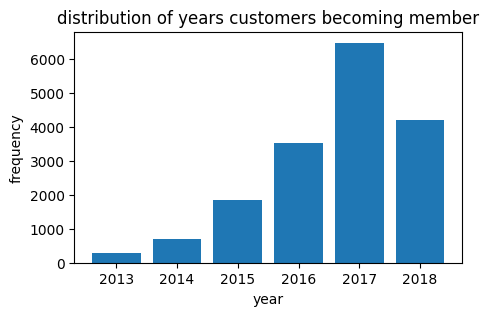

In [867]:
#create a bar chart with the frequency of every year
year_distribution = profile.groupby(["became_member_year"]).count().reset_index()[['became_member_year',"id"]] 
plt.figure(figsize=(5, 3))
create_bar_chart(year_distribution["became_member_year"],year_distribution['id'],'year','frequency','distribution of years customers becoming member')

Most people joined in 2017.

**Transcript dataset**

In [868]:
print(transcript.shape[0])
transcript.head(5)

306534


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


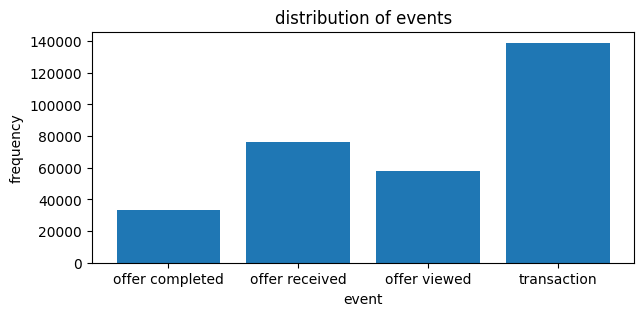

In [869]:
#show the distribution of events
event_distribution = transcript.groupby(['event']).count().reset_index()[['event',"person"]]
plt.figure(figsize=(7, 3))
create_bar_chart(event_distribution['event'], event_distribution['person'], 'event', 'frequency', 'distribution of events')


In [870]:
#check for nan values
print(transcript.isna().any()) #--> no nan values

person    False
event     False
value     False
time      False
dtype: bool


In [871]:
transcript["time"].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

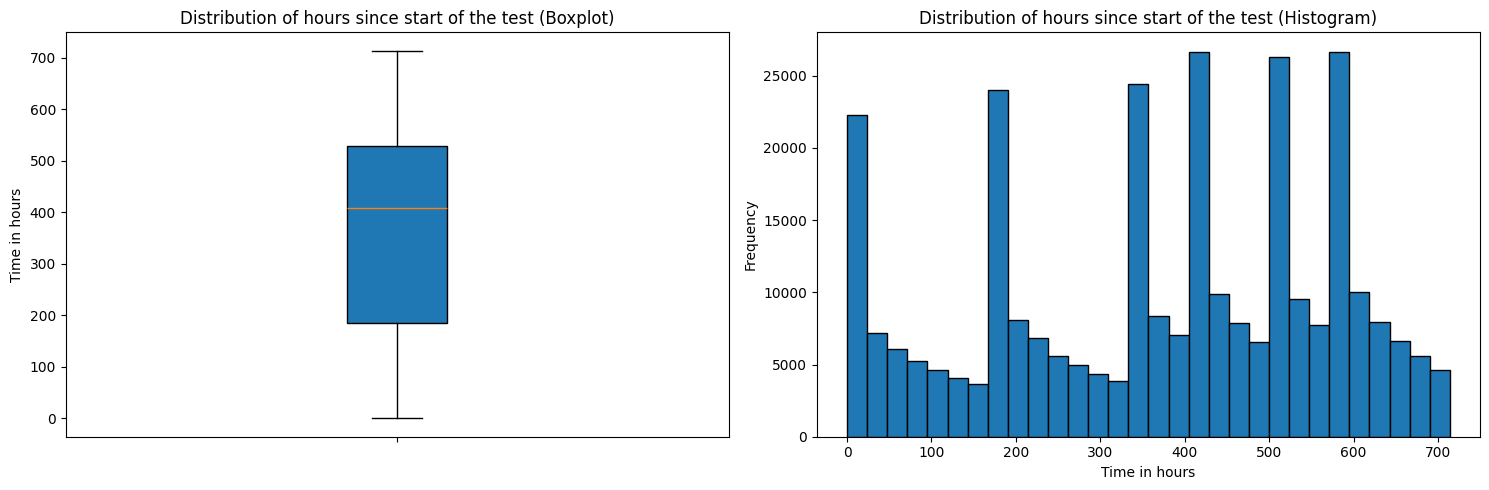

In [872]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
create_boxplot(transcript["time"],'Distribution of hours since start of the test (Boxplot)',[1],[''],np.arange(0, 800, 100),'Time in hours')
plt.subplot(1, 2, 2)
create_histogram(transcript["time"], int(round(714/24,0)),'Distribution of hours since start of the test (Histogram)','Time in hours','Frequency')
plt.tight_layout()
plt.show()

## 3. Data Processing

#### Data Cleaning

**Portfolio Dataset**

In [873]:
#transfer channels column into 4 columns (1 for each channel) with values 1 and 0
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio = portfolio.drop(columns=["channels"])

In [874]:
#calculate a new column reward in %
portfolio['reward_in_percent'] = np.where(portfolio['difficulty'] != 0, portfolio['reward'] / portfolio['difficulty'] * 100,0)

In [875]:
#rename id column into offer_id
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

In [876]:
#convert categorical variable offer_type into dummy variables (with values of 0 and 1)
offer_dummies = pd.get_dummies(portfolio['offer_type'], prefix='offer_type').astype(int)

# Concatenate the dummy variables with the original DataFrame and set offer id as index
portfolio = pd.concat([portfolio, offer_dummies], axis=1).drop(columns=["offer_type"]).set_index('offer_id')

In [877]:
portfolio.head(10)

,reward,difficulty,duration,channel_email,channel_mobile,channel_web,channel_social,reward_in_percent,offer_type_bogo,offer_type_discount,offer_type_informational
offer_id,,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,0,1,100.000000,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,100.000000,1,0,0
3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,1,0,0.000000,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,1,0,100.000000,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,1,0,25.000000,0,1,0
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,42.857143,0,1,0
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,20.000000,0,1,0
5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,0,1,0.000000,0,0,1
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,100.000000,1,0,0


**Profile Dataset**

In [878]:
#rename id column into customer_id
profile.rename(columns={"id": "customer_id"}, inplace=True)

In [879]:
#insert nan values
profile['gender'] = profile['gender'].fillna("not_specified")
profile['income'] = profile['income'].fillna(profile['income'].median())

#treat age of 118 as nan values and insert mean
profile['age'] = profile['age'].replace(118, np.nan)
profile['age'] = profile['age'].fillna(profile['age'].median())

In [880]:
#convert categorical variable gender into dummy variables (with values of 0 and 1)
gender_dummies = pd.get_dummies(profile['gender'], prefix='gender').astype(int)

# Concatenate the dummy variables with the original DataFrame and set customer id as index
profile = pd.concat([profile, gender_dummies], axis=1).drop(columns=["gender"]).set_index('customer_id')
profile.head(10)

,age,income,became_member_year,became_member_month,became_member_day,gender_F,gender_M,gender_O,gender_not_specified
customer_id,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,55.0,64000.0,2017,2,12,0,0,0,1
0610b486422d4921ae7d2bf64640c50b,55.0,112000.0,2017,7,15,1,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,55.0,64000.0,2018,7,12,0,0,0,1
78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,2017,5,9,1,0,0,0
a03223e636434f42ac4c3df47e8bac43,55.0,64000.0,2017,8,4,0,0,0,1
e2127556f4f64592b11af22de27a7932,68.0,70000.0,2018,4,26,0,1,0,0
8ec6ce2a7e7949b1bf142def7d0e0586,55.0,64000.0,2017,9,25,0,0,0,1
68617ca6246f4fbc85e91a2a49552598,55.0,64000.0,2017,10,2,0,0,0,1
389bc3fa690240e798340f5a15918d5c,65.0,53000.0,2018,2,9,0,1,0,0


**Transcript dataset**

In [881]:
#rename person column into customer_id
transcript.rename(columns={"person": "customer_id"}, inplace=True)

In [882]:
#split the column value by the ":" and create three new columns for offer_id, amount (reward is left out because the information is already given in the portfolio dataset)
def extract_offer_and_amount(row):
    # Convert the string to a dictionary
    value_dict = ast.literal_eval(str(row['value']).replace("'", '"'))
    # Extract values
    offer_id = value_dict.get('offer id', value_dict.get('offer_id', None))  # Get offer id or None if not present (sometimes the offer id is given with "offer_id:" and sometimes with "offer id:" depending on the event")
    amount = value_dict.get('amount', None)  # Get amount or None if not present
    return pd.Series([offer_id, amount])  # Return as a Series

# Apply the function to create new columns
transcript[['offer_id', 'amount']] = transcript.apply(extract_offer_and_amount, axis=1)
transcript = transcript.drop(columns=["value"])

In [883]:
#split dataset into two new datasets offers and transactions
transactions = transcript.query('event == "transaction"').drop(columns=["offer_id","event"])
offers = transcript.query('event != "transaction"').drop(columns=["amount"])

In [884]:
# convert categorical variable event into dummy variables (with values of 0 and 1)
event_dummies = pd.get_dummies(offers['event']).astype(int)

# Concatenate the dummy variables with the original DataFrame
offers = pd.concat([offers, event_dummies], axis=1).drop(columns=["event"])
offers = offers.rename(columns={"offer completed": "offer_completed", "offer received": "offer_received", "offer viewed": "offer_viewed"})

# I would like to see in one line if an offer was seen, reveived and viewed by a specific user, independent from the time the event occurs. Therefore I will create an identifier for the user and offer combination and then aggregate the dataframe.
offers["customer_offer_combination"] = offers['customer_id'] + offers['offer_id']
offers = offers.groupby(["customer_offer_combination"]).agg({"offer_completed": "sum", "offer_received": "sum", "offer_viewed": "sum", 'customer_id': "first", 'offer_id': "first"})

In [885]:
offers.head(10)

,offer_completed,offer_received,offer_viewed,customer_id,offer_id
customer_offer_combination,,,,,
0009655768c64bdeb2e877511632db8f2906b810c7d4411798c6938adc9daaa5,1,1,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5
0009655768c64bdeb2e877511632db8f3f207df678b143eea3cee63160fa8bed,0,1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed
0009655768c64bdeb2e877511632db8f5a8bc65990b245e5a138643cd4eb9837,0,1,1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837
0009655768c64bdeb2e877511632db8ff19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d
0009655768c64bdeb2e877511632db8ffafdcd668e3743c1bb461111dcafc2a4,1,1,1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4
00116118485d4dfda04fdbaba9a87b5cf19421c1d4aa40978ebb69ca19b0e20d,0,2,2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d
0011e0d4e6b944f998e987f904e8c1e50b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7
0011e0d4e6b944f998e987f904e8c1e52298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2
0011e0d4e6b944f998e987f904e8c1e53f207df678b143eea3cee63160fa8bed,0,1,1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed


In [886]:
#aggregating the transactions dataset to see which user spent how much in total
transactions = transactions.groupby(["customer_id"]).sum().drop(columns=["time"])
transactions['tot_amt_spent_by_customer'] = transactions["amount"]
transactions = transactions.drop(columns=["amount"])

In [887]:
transactions.head(10)

,tot_amt_spent_by_customer
customer_id,
0009655768c64bdeb2e877511632db8f,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46
0020c2b971eb4e9188eac86d93036a77,196.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05
003d66b6608740288d6cc97a6903f4f0,48.34
00426fe3ffde4c6b9cb9ad6d077a13ea,68.51
004b041fbfe44859945daa2c7f79ee64,138.36
004c5799adbf42868b9cff0396190900,347.38


**Merging the datasets to one cleaned datset**

In [888]:
#merging offers and transactions with each other
df = pd.merge(offers, transactions, on='customer_id', how='left')

#now adding the information from profile and portfolio
df = pd.merge(df, portfolio, on='offer_id', how='left')
df = pd.merge(df, profile, on='customer_id', how='left')
#if customer does not have a transaction amount, fill with value 0
df["tot_amt_spent_by_customer"] = df["tot_amt_spent_by_customer"].fillna(0)

In [889]:
print(df.columns)
print(df.shape)
df.head(10)

Index(['offer_completed', 'offer_received', 'offer_viewed', 'customer_id',
       'offer_id', 'tot_amt_spent_by_customer', 'reward', 'difficulty',
       'duration', 'channel_email', 'channel_mobile', 'channel_web',
       'channel_social', 'reward_in_percent', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'age', 'income',
       'became_member_year', 'became_member_month', 'became_member_day',
       'gender_F', 'gender_M', 'gender_O', 'gender_not_specified'],
      dtype='object')
(63288, 26)


,offer_completed,offer_received,offer_viewed,customer_id,offer_id,tot_amt_spent_by_customer,reward,difficulty,duration,channel_email,...,offer_type_informational,age,income,became_member_year,became_member_month,became_member_day,gender_F,gender_M,gender_O,gender_not_specified
0,1,1,0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,127.60,2,10,7,1,...,0,33.0,72000.0,2017,4,21,0,1,0,0
1,0,1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,127.60,0,0,4,1,...,1,33.0,72000.0,2017,4,21,0,1,0,0
2,0,1,1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,127.60,0,0,3,1,...,1,33.0,72000.0,2017,4,21,0,1,0,0
3,1,1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,127.60,5,5,5,1,...,0,33.0,72000.0,2017,4,21,0,1,0,0
4,1,1,1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,127.60,2,10,10,1,...,0,33.0,72000.0,2017,4,21,0,1,0,0
5,0,2,2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,4.09,5,5,5,1,...,0,55.0,64000.0,2018,4,25,0,0,0,1
6,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,79.46,5,20,10,1,...,0,40.0,57000.0,2018,1,9,0,0,1,0
7,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,79.46,3,7,7,1,...,0,40.0,57000.0,2018,1,9,0,0,1,0
8,0,1,1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,79.46,0,0,4,1,...,1,40.0,57000.0,2018,1,9,0,0,1,0
9,0,1,1,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,79.46,0,0,3,1,...,1,40.0,57000.0,2018,1,9,0,0,1,0


#### Implementation

In [890]:
#show how often every offer was completed
offer_events_count = df.groupby(["offer_id"]).agg({"offer_completed": "sum", "offer_received": "sum", "offer_viewed": "sum"})

In [891]:
#check if sum of offer events still remains the same and if df is calculated correctly --> yes
print(sum(offer_events_count["offer_completed"]))
print(sum(offer_events_count["offer_received"]))
print(sum(offer_events_count["offer_viewed"]))
print(event_distribution)

33579
76277
57725
             event  person
0  offer completed   33579
1   offer received   76277
2     offer viewed   57725
3      transaction  138953


In [892]:
#now I want to check how this number changes when only looking at the viewed offers
df_only_viewed = df[df['offer_viewed'] != 0]
offer_events_count_only_viewed = df_only_viewed.groupby(["offer_id"]).agg({"offer_completed": "sum", "offer_received": "sum", "offer_viewed": "sum"})

In [893]:
offer_events_count.head(10)

,offer_completed,offer_received,offer_viewed
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420,7668,2663
2298d6c36e964ae4a3e7e9706d1fb8c2,5156,7646,7337
2906b810c7d4411798c6938adc9daaa5,4017,7632,4118
3f207df678b143eea3cee63160fa8bed,0,7617,4144
4d5c57ea9a6940dd891ad53e9dbe8da0,3331,7593,7298
5a8bc65990b245e5a138643cd4eb9837,0,7618,6687
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354,7677,4171
ae264e3637204a6fb9bb56bc8210ddfd,3688,7658,6716
f19421c1d4aa40978ebb69ca19b0e20d,4296,7571,7264


In [894]:
offer_events_count_only_viewed.head(10)

,offer_completed,offer_received,offer_viewed
offer_id,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,1772,3023,2663
2298d6c36e964ae4a3e7e9706d1fb8c2,5048,7440,7337
2906b810c7d4411798c6938adc9daaa5,2878,4578,4118
3f207df678b143eea3cee63160fa8bed,0,4558,4144
4d5c57ea9a6940dd891ad53e9dbe8da0,3271,7395,7298
5a8bc65990b245e5a138643cd4eb9837,0,6937,6687
9b98b8c7a33c4b65b9aebfe6a799e6d9,2978,4625,4171
ae264e3637204a6fb9bb56bc8210ddfd,3347,6948,6716
f19421c1d4aa40978ebb69ca19b0e20d,4210,7367,7264


In [895]:
#in the following I will just use the offers which were viewed, as there is no effect of an offer if it was not viewed
df = df_only_viewed
#i want to devide the dataframe into completed and not completed offers
df_completed = df[df['offer_completed'] != 0]
df_not_completed = df[df['offer_completed'] == 0]

In [896]:
df.head(10)

,offer_completed,offer_received,offer_viewed,customer_id,offer_id,tot_amt_spent_by_customer,reward,difficulty,duration,channel_email,...,offer_type_informational,age,income,became_member_year,became_member_month,became_member_day,gender_F,gender_M,gender_O,gender_not_specified
1,0,1,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,127.60,0,0,4,1,...,1,33.0,72000.0,2017,4,21,0,1,0,0
2,0,1,1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,127.60,0,0,3,1,...,1,33.0,72000.0,2017,4,21,0,1,0,0
3,1,1,1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,127.60,5,5,5,1,...,0,33.0,72000.0,2017,4,21,0,1,0,0
4,1,1,1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,127.60,2,10,10,1,...,0,33.0,72000.0,2017,4,21,0,1,0,0
5,0,2,2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,4.09,5,5,5,1,...,0,55.0,64000.0,2018,4,25,0,0,0,1
6,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,79.46,5,20,10,1,...,0,40.0,57000.0,2018,1,9,0,0,1,0
7,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,79.46,3,7,7,1,...,0,40.0,57000.0,2018,1,9,0,0,1,0
8,0,1,1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,79.46,0,0,4,1,...,1,40.0,57000.0,2018,1,9,0,0,1,0
9,0,1,1,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,79.46,0,0,3,1,...,1,40.0,57000.0,2018,1,9,0,0,1,0
10,1,1,1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,79.46,5,5,7,1,...,0,40.0,57000.0,2018,1,9,0,0,1,0


I will create a correlation matrix to check which variables could have correlations with each other.

<Axes: title={'center': 'Correlation'}>

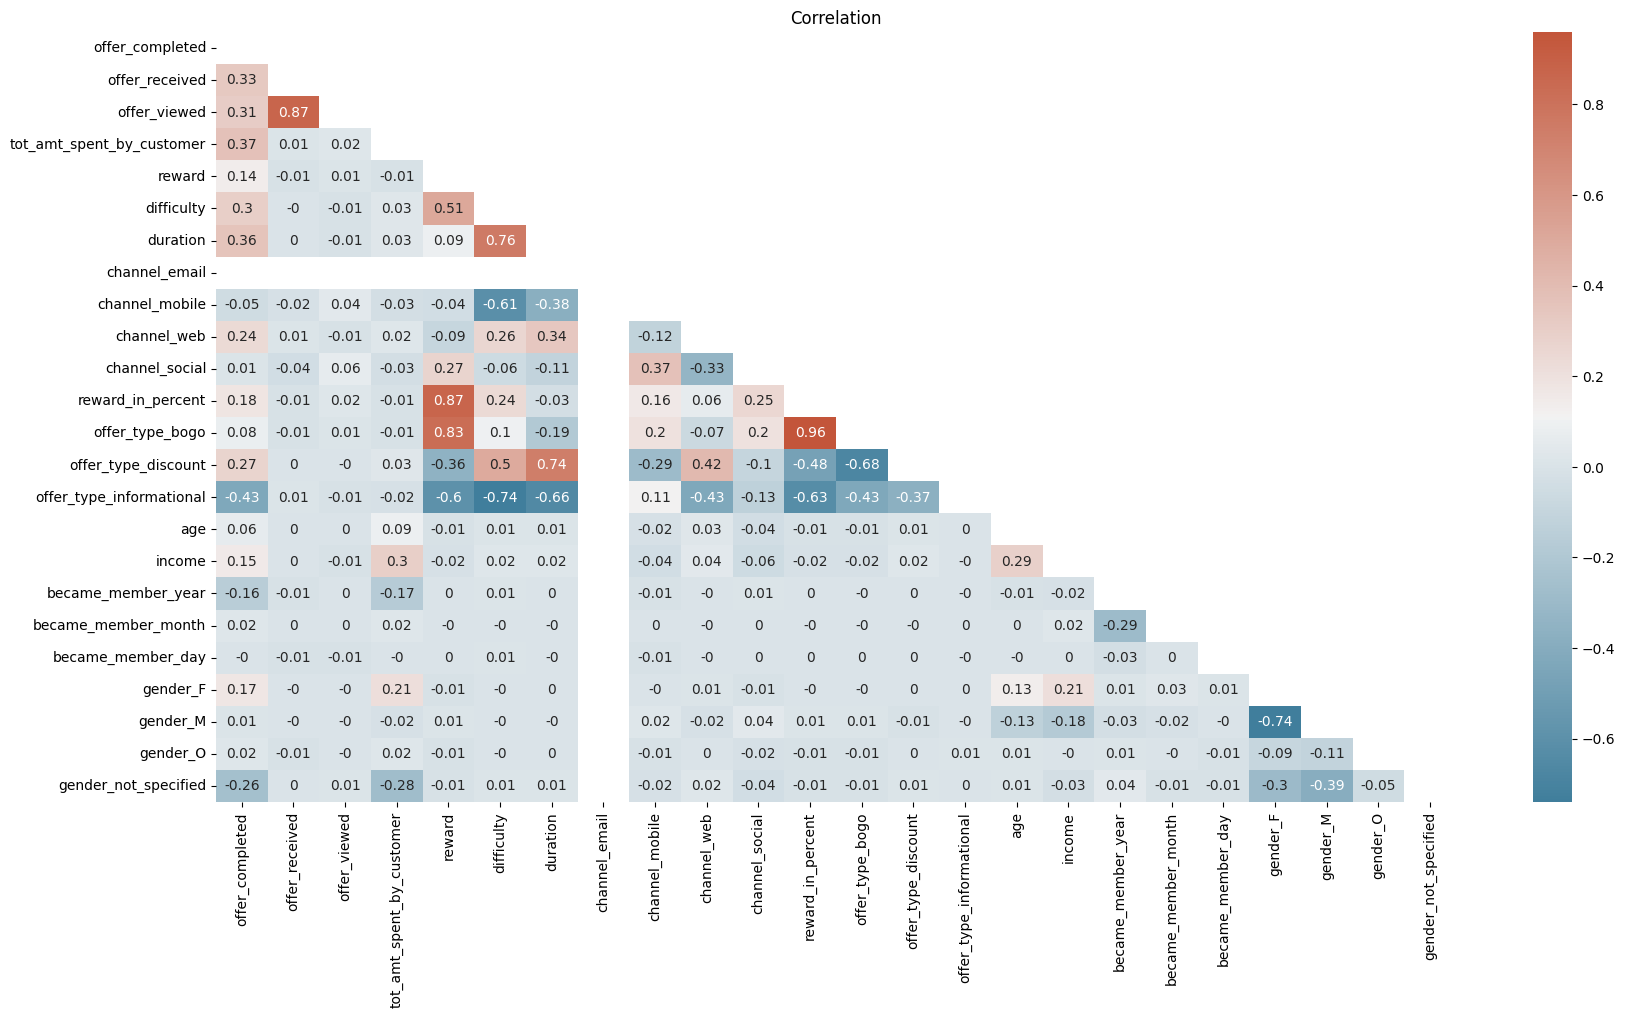

In [ ]:
df_small = df.drop(columns=["offer_id","customer_id"])
#Create a correlation heatmap
plt.figure(figsize=[20,10])
plt.title("Correlation")
sns.heatmap(df_small.corr(method='pearson', min_periods=1).round(2), mask= np.triu(np.ones_like(df_small.corr(), dtype=bool)), \
    annot=True, cmap=sns.diverging_palette(230, 20, as_cmap=True))

The correlation matrix does not show high significances between variables that could lead to conclusions on demographic groups. Thats why I will adress the question with heuristics and data visualization.

In [897]:
#which offer types have best completion rate
offer_types_completion_rate = [df_completed["offer_type_bogo"].sum()/df["offer_type_bogo"].sum(), df_completed["offer_type_discount"].sum()/df["offer_type_discount"].sum(), df_completed["offer_type_informational"].sum()/df["offer_type_informational"].sum()]

#which channels have best completion rate
channels_completion_rate = [df_completed["channel_email"].sum()/df["channel_email"].sum(), df_completed["channel_mobile"].sum()/df["channel_mobile"].sum(), df_completed["channel_web"].sum()/df["channel_web"].sum(), df_completed["channel_social"].sum()/df["channel_social"].sum()]

#which genders have best completion rate
genders_completion_rate = [df_completed["gender_F"].sum()/df["gender_F"].sum(), df_completed["gender_M"].sum()/df["gender_M"].sum(), df_completed["gender_O"].sum()/df["gender_O"].sum(), df_completed["gender_not_specified"].sum()/df["gender_not_specified"].sum()]



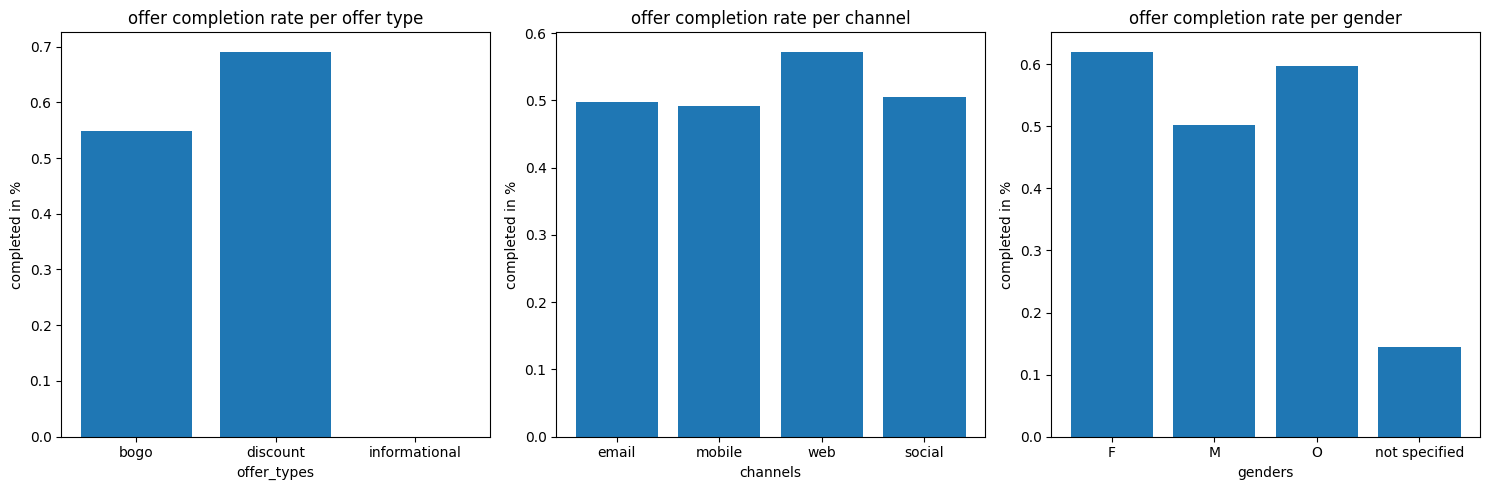

[np.float64(0.548918592778242), np.float64(0.6910831509846828), np.float64(0.0)] [np.float64(0.4978121501984329), np.float64(0.49187974751257085), np.float64(0.5724083145769893), np.float64(0.5042417815482503)] [np.float64(0.6206429780033841), np.float64(0.5020535158680771), np.float64(0.5972644376899696), np.float64(0.14468533574224632)]


In [918]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
create_bar_chart(['bogo','discount','informational'],offer_types_completion_rate,'offer_types','completed in %','offer completion rate per offer type')
plt.subplot(1, 3, 2)
create_bar_chart(['email','mobile','web',"social"],channels_completion_rate,'channels','completed in %','offer completion rate per channel')
plt.subplot(1, 3, 3)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate,'genders','completed in %','offer completion rate per gender')

plt.tight_layout()
plt.show()

print(offer_types_completion_rate, channels_completion_rate, genders_completion_rate)

Over all discount offers have the highest completion rate (69%). Offers that were sent by the web have a slightly higher completion rate than the other channels (57% vs about 50%). Female customers have the highest completion rates (62%). However, other genders are following straight behind (60%).

In [899]:
#look into offers types and channels completed by female customers
df_gender_F = df[df["gender_F"] == 1]
df_gender_F_completed = df_completed[df_completed["gender_F"] == 1]
channels_completion_rate_gender_F = [df_gender_F_completed["channel_email"].sum()/df_gender_F["channel_email"].sum(), df_gender_F_completed["channel_mobile"].sum()/df_gender_F["channel_mobile"].sum(), df_gender_F_completed["channel_web"].sum()/df_gender_F["channel_web"].sum(), df_gender_F_completed["channel_social"].sum()/df_gender_F["channel_social"].sum()]
offer_type_completion_rate_gender_F = [df_gender_F_completed["offer_type_bogo"].sum()/df_gender_F["offer_type_bogo"].sum(), df_gender_F_completed["offer_type_discount"].sum()/df_gender_F["offer_type_discount"].sum(), df_gender_F_completed["offer_type_informational"].sum()/df_gender_F["offer_type_informational"].sum()]

#look into offers types and channels completed by male customers
df_gender_M = df[df["gender_M"] == 1]
df_gender_M_completed = df_completed[df_completed["gender_M"] == 1]
channels_completion_rate_gender_M = [df_gender_M_completed["channel_email"].sum()/df_gender_M["channel_email"].sum(), df_gender_M_completed["channel_mobile"].sum()/df_gender_M["channel_mobile"].sum(), df_gender_M_completed["channel_web"].sum()/df_gender_M["channel_web"].sum(), df_gender_M_completed["channel_social"].sum()/df_gender_M["channel_social"].sum()]
offer_type_completion_rate_gender_M = [df_gender_M_completed["offer_type_bogo"].sum()/df_gender_M["offer_type_bogo"].sum(), df_gender_M_completed["offer_type_discount"].sum()/df_gender_M["offer_type_discount"].sum(), df_gender_M_completed["offer_type_informational"].sum()/df_gender_M["offer_type_informational"].sum()]

#look into offers types and channels completed by gender other
df_gender_O = df[df["gender_O"] == 1]
df_gender_O_completed = df_completed[df_completed["gender_O"] == 1]
channels_completion_rate_gender_O = [df_gender_O_completed["channel_email"].sum()/df_gender_O["channel_email"].sum(), df_gender_O_completed["channel_mobile"].sum()/df_gender_O["channel_mobile"].sum(), df_gender_O_completed["channel_web"].sum()/df_gender_O["channel_web"].sum(), df_gender_O_completed["channel_social"].sum()/df_gender_O["channel_social"].sum()]
offer_type_completion_rate_gender_O = [df_gender_O_completed["offer_type_bogo"].sum()/df_gender_O["offer_type_bogo"].sum(), df_gender_O_completed["offer_type_discount"].sum()/df_gender_O["offer_type_discount"].sum(), df_gender_O_completed["offer_type_informational"].sum()/df_gender_O["offer_type_informational"].sum()]


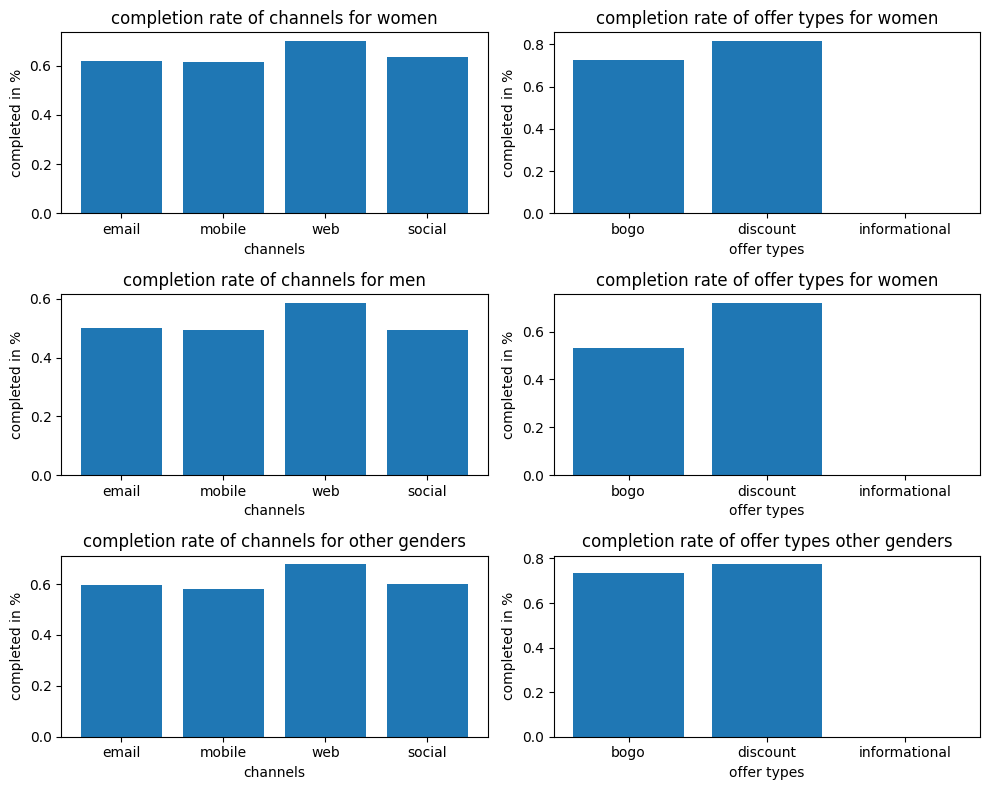

In [900]:
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
plt.subplot(3, 2, 1)
create_bar_chart(['email','mobile','web',"social"],channels_completion_rate_gender_F,'channels','completed in %','completion rate of channels for women')
plt.subplot(3, 2, 2)
create_bar_chart(['bogo','discount','informational'],offer_type_completion_rate_gender_F,'offer types','completed in %','completion rate of offer types for women')
plt.subplot(3, 2, 3)
create_bar_chart(['email','mobile','web',"social"],channels_completion_rate_gender_M,'channels','completed in %','completion rate of channels for men')
plt.subplot(3, 2, 4)
create_bar_chart(['bogo','discount','informational'],offer_type_completion_rate_gender_M,'offer types','completed in %','completion rate of offer types for men')
plt.subplot(3, 2, 5)
create_bar_chart(['email','mobile','web',"social"],channels_completion_rate_gender_O,'channels','completed in %','completion rate of channels for other genders')
plt.subplot(3, 2, 6)
create_bar_chart(['bogo','discount','informational'],offer_type_completion_rate_gender_O,'offer types','completed in %','completion rate of offer types other genders')
plt.tight_layout()
plt.show()

There is no noticeable difference in completion rates of the different channels when looking at the genders. Fo offer types, you can see that the difference in completion rate between bogo and discount is highest for men.

In [901]:
#which reward percentages has the most completed offers
def aggregated_df_reward_in_percent_completed(df):
    reward_in_percent_completed = df.groupby(['reward_in_percent']).agg({"offer_completed": "sum"}).reset_index()
    return reward_in_percent_completed

def aggregated_df_reward_in_percent_completion_rate(df):
    reward_in_percent_viewed = df.groupby(['reward_in_percent']).agg({"offer_viewed": "sum"}).reset_index()
    reward_in_percent_completion_rate = pd.merge(aggregated_df_reward_in_percent_completed(df), reward_in_percent_viewed, on='reward_in_percent', how='left')
    reward_in_percent_completion_rate["offer_completion_rate"] = new["offer_completed"] / new["offer_viewed"]
    return reward_in_percent_completion_rate

#which ages have the most completed offers
def aggregated_df_ages_completed(df):
    ages_completed = df.groupby(['age']).agg({"offer_completed": "sum"}).reset_index()
    return ages_completed
    
def aggregated_df_ages_completed_completion_rate(df):    
    ages_viewed = df.groupby(['age']).agg({"offer_viewed": "sum"}).reset_index()
    ages_completion_rate = pd.merge(aggregated_df_ages_completed(df), ages_viewed, on='age', how='left')
    ages_completion_rate["ages_completion_rate"] = ages_completion_rate["offer_completed"] / ages_completion_rate["offer_viewed"]
    return ages_completion_rate

#which incomes have the most completed offers
def aggregated_df_income_completed(df):
    income_completed = df.groupby(['income']).agg({"offer_completed": "sum"}).reset_index()
    return income_completed

def aggregated_df_income_completion_rate(df):  
    income_viewed = df.groupby(['income']).agg({"offer_viewed": "sum"}).reset_index()
    income_completion_rate = pd.merge(aggregated_df_income_completed(df), income_viewed, on='income', how='left')
    income_completion_rate["income_completion_rate"] = income_completion_rate["offer_completed"] / income_completion_rate["offer_viewed"]
    return income_completion_rate

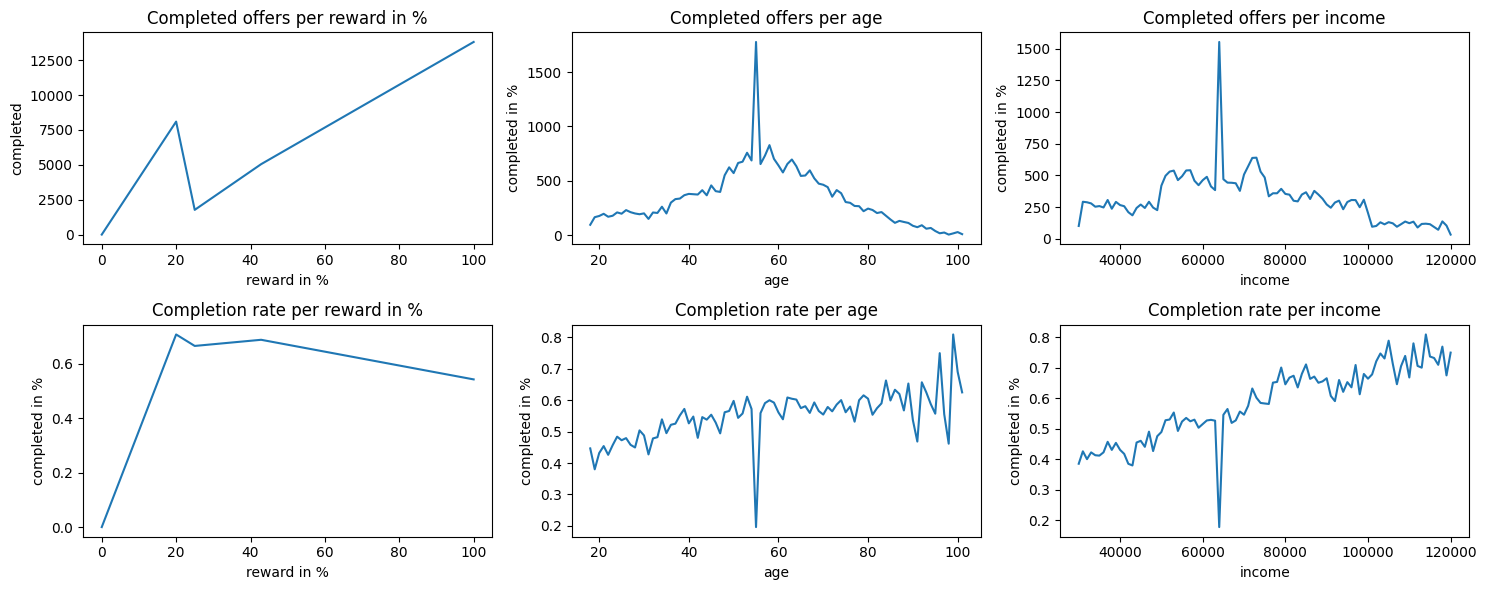

In [923]:
def create_linegraph(x_values, y_values, x_label, y_label, title):
    plt.plot(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

reward_in_percent_completed = aggregated_df_reward_in_percent_completed(df)
reward_in_percent_completion_rate = aggregated_df_reward_in_percent_completion_rate(df)
ages_completed = aggregated_df_ages_completed(df)
ages_completion_rate = aggregated_df_ages_completed_completion_rate(df)
income_completed = aggregated_df_income_completed(df)
income_completion_rate = aggregated_df_income_completion_rate(df)

fig, axs = plt.subplots(2, 3, figsize=(15, 6))
plt.subplot(2, 3, 1)
create_linegraph(reward_in_percent_completed["reward_in_percent"], reward_in_percent_completed["offer_completed"], 'reward in %', 'completed', 'Completed offers per reward in %')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed["age"], ages_completed["offer_completed"], 'age', 'completed in %', 'Completed offers per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed["income"], income_completed["offer_completed"], 'income', 'completed in %', 'Completed offers per income')
plt.subplot(2, 3, 4)
create_linegraph(reward_in_percent_completion_rate["reward_in_percent"], reward_in_percent_completion_rate["offer_completion_rate"], 'reward in %', 'completed in %', 'Completion rate per reward in %')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate["age"], ages_completion_rate["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate["income"], income_completion_rate["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

plt.tight_layout()
plt.show()


You can see a strong relation between number of completed offers and reward in percent. However, when looking at the completion rate there is a slight decrease the higher the reward gets. 
The completion rate rises with age as well as income of the customer. However, the number of completed offers in total decreases with rising income and age, as there is a decreasing number of customers.


In [903]:
#same graphs but seperated by gender
ages_completed_F = aggregated_df_ages_completed(df_gender_F)
ages_completion_rate_F = aggregated_df_ages_completed_completion_rate(df_gender_F)
income_completed_F = aggregated_df_income_completed(df_gender_F)
income_completion_rate_F = aggregated_df_income_completion_rate(df_gender_F)
print(income_completion_rate_F)
ages_completed_M = aggregated_df_ages_completed(df_gender_M)
ages_completion_rate_M = aggregated_df_ages_completed_completion_rate(df_gender_M)
income_completed_M = aggregated_df_income_completed(df_gender_M)
income_completion_rate_M = aggregated_df_income_completion_rate(df_gender_M)

ages_completed_O = aggregated_df_ages_completed(df_gender_O)
ages_completion_rate_O = aggregated_df_ages_completed_completion_rate(df_gender_O)
income_completed_O = aggregated_df_income_completed(df_gender_O)
income_completion_rate_O = aggregated_df_income_completion_rate(df_gender_O)

      income  offer_completed  offer_viewed  income_completion_rate
0    30000.0               24            69                0.347826
1    31000.0              115           243                0.473251
2    32000.0              105           203                0.517241
3    33000.0              115           210                0.547619
4    34000.0               83           165                0.503030
..       ...              ...           ...                     ...
86  116000.0               56            80                0.700000
87  117000.0               40            49                0.816327
88  118000.0               99           130                0.761538
89  119000.0               66           105                0.628571
90  120000.0               20            25                0.800000

[91 rows x 4 columns]


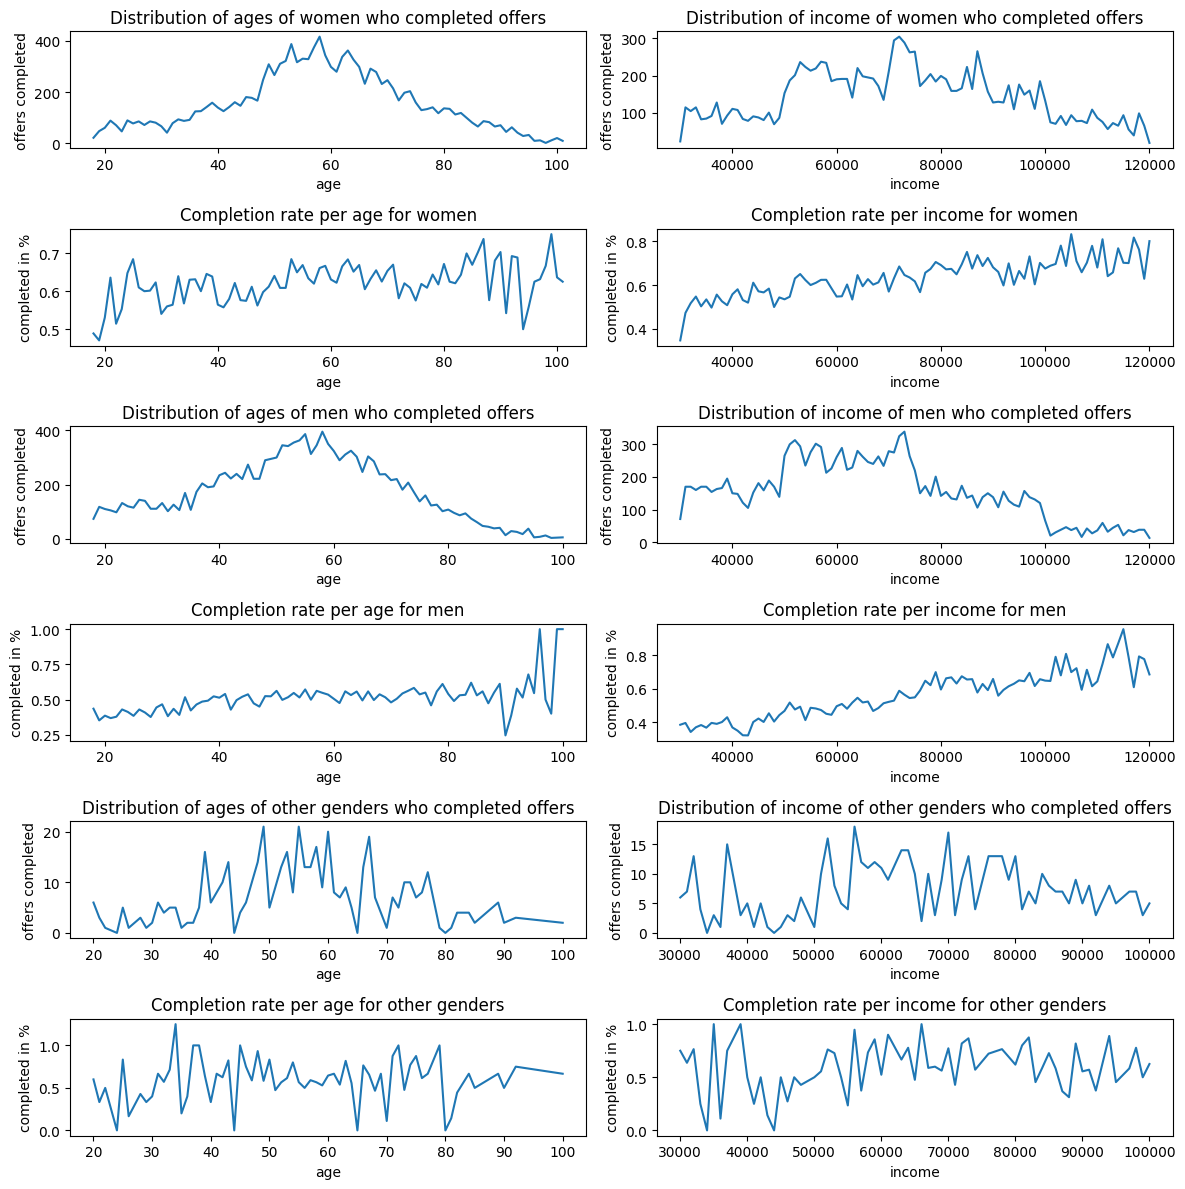

In [924]:
fig, axs = plt.subplots(6,2, figsize=(12,12))
plt.subplot(6, 2, 1)
create_linegraph(ages_completed_F["age"], ages_completed_F["offer_completed"], 'age', 'offers completed', 'Distribution of ages of women who completed offers')
plt.subplot(6, 2, 2)
create_linegraph(income_completed_F["income"], income_completed_F["offer_completed"], 'income', 'offers completed', 'Distribution of income of women who completed offers')
plt.subplot(6, 2, 3)
create_linegraph(ages_completion_rate_F["age"], ages_completion_rate_F["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age for women')
plt.subplot(6, 2, 4)
create_linegraph(income_completion_rate_F["income"], income_completion_rate_F["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income for women')

plt.subplot(6, 2, 5)
create_linegraph(ages_completed_M["age"], ages_completed_M["offer_completed"], 'age', 'offers completed', 'Distribution of ages of men who completed offers')
plt.subplot(6, 2, 6)
create_linegraph(income_completed_M["income"], income_completed_M["offer_completed"], 'income', 'offers completed', 'Distribution of income of men who completed offers')
plt.subplot(6, 2, 7)
create_linegraph(ages_completion_rate_M["age"], ages_completion_rate_M["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age for men')
plt.subplot(6, 2, 8)
create_linegraph(income_completion_rate_M["income"], income_completion_rate_M["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income for men')

plt.subplot(6, 2, 9)
create_linegraph(ages_completed_O["age"], ages_completed_O["offer_completed"], 'age', 'offers completed', 'Distribution of ages of other genders who completed offers')
plt.subplot(6, 2, 10)
create_linegraph(income_completed_O["income"], income_completed_O["offer_completed"], 'income', 'offers completed', 'Distribution of income of other genders who completed offers')
plt.subplot(6, 2, 11)
create_linegraph(ages_completion_rate_O["age"], ages_completion_rate_O["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age for other genders')
plt.subplot(6, 2, 12)
create_linegraph(income_completion_rate_O["income"], income_completion_rate_O["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income for other genders')
plt.tight_layout()
plt.show()

The effect that completion rate increases with income is stronger for men than for woman. For other genders this trend cannot be seen at all.

In [ ]:
df_offer_type_bogo = df[df["offer_type_bogo"] == 1]
df_offer_type_discount = df[df["offer_type_discount"] == 1]

In [ ]:
#same graphs but seperated by offer type
ages_completed_bogo = aggregated_df_ages_completed(df_offer_type_bogo)
ages_completion_rate_bogo = aggregated_df_ages_completed_completion_rate(df_offer_type_bogo)
income_completed_bogo = aggregated_df_income_completed(df_offer_type_bogo)
income_completion_rate_bogo = aggregated_df_income_completion_rate(df_offer_type_bogo)

ages_completed_discount = aggregated_df_ages_completed(df_offer_type_discount)
ages_completion_rate_discount = aggregated_df_ages_completed_completion_rate(df_offer_type_discount)
income_completed_discount = aggregated_df_income_completed(df_offer_type_discount)
income_completion_rate_discount = aggregated_df_income_completion_rate(df_offer_type_discount)

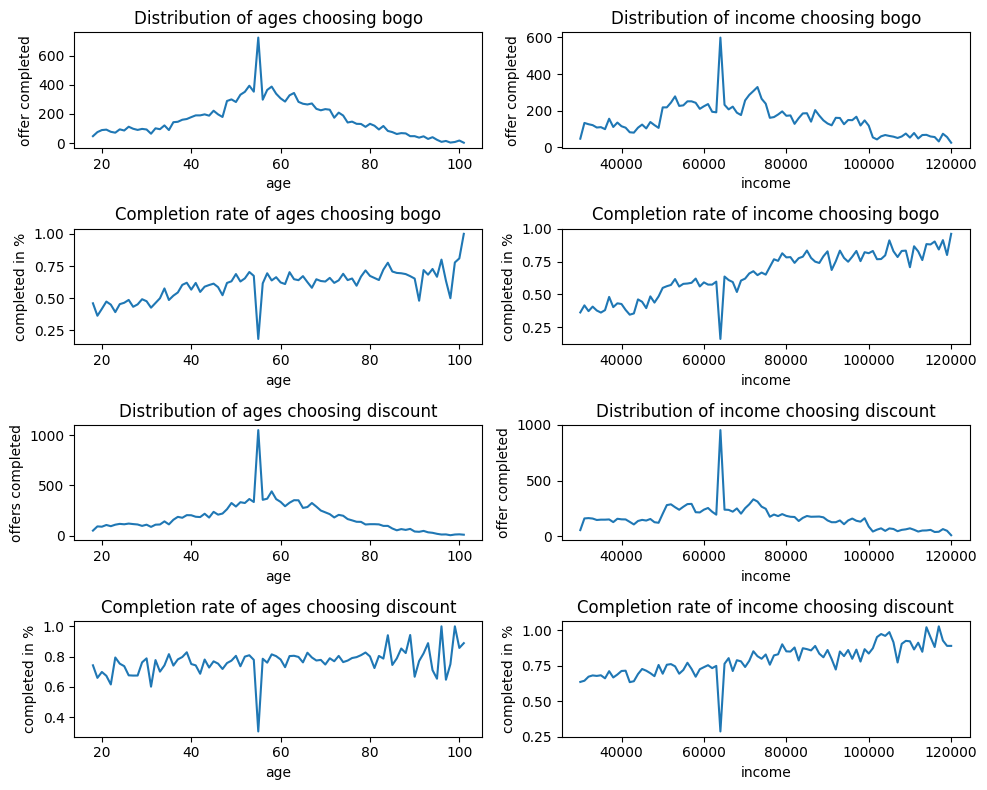

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))
plt.subplot(4, 2, 1)
create_linegraph(ages_completed_bogo['age'], ages_completed_bogo["offer_completed"], 'age', 'offer completed', 'Distribution of ages choosing bogo')
plt.subplot(4, 2, 2)
create_linegraph(income_completed_bogo['income'], income_completed_bogo["offer_completed"], 'income', 'offer completed', 'Distribution of income choosing bogo')
plt.subplot(4, 2, 3)
create_linegraph(ages_completion_rate_bogo['age'], ages_completion_rate_bogo["ages_completion_rate"], 'age', 'completed in %', 'Completion rate of ages choosing bogo')
plt.subplot(4, 2, 4)
create_linegraph(income_completion_rate_bogo['income'], income_completion_rate_bogo["income_completion_rate"], 'income', 'completed in %', 'Completion rate of income choosing bogo')
plt.subplot(4, 2, 5)
create_linegraph(ages_completed_discount["age"], ages_completed_discount["offer_completed"], 'age', 'offers completed', 'Distribution of ages choosing discount')
plt.subplot(4, 2, 6)
create_linegraph(income_completed_discount['income'], income_completed_discount["offer_completed"], 'income', 'offer completed', 'Distribution of income choosing discount')
plt.subplot(4, 2, 7)
create_linegraph(ages_completion_rate_discount["age"], ages_completion_rate_discount["ages_completion_rate"], 'age', 'completed in %', 'Completion rate of ages choosing discount')
plt.subplot(4, 2, 8)
create_linegraph(income_completion_rate_discount['income'], income_completion_rate_discount["income_completion_rate"], 'income', 'completed in %', 'Completion rate of income choosing discount')
plt.tight_layout()
plt.show()


The effect that completion rate increases with income and age is stronger for bogo than for discount offers. 

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7000000000000001, 0, '0.7'),
  Text(0.8, 0, '0.8')])

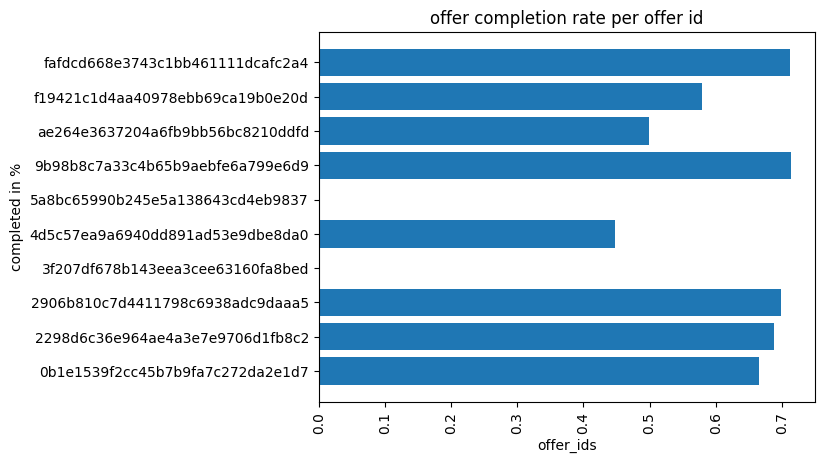

In [ ]:
offer_id_completed = df.groupby(['offer_id']).agg({"offer_completed": "sum"}).reset_index()
offer_id_viewed = df.groupby(['offer_id']).agg({"offer_viewed": "sum"}).reset_index()
offer_id_completion_rate = pd.merge(offer_id_completed, offer_id_viewed, on='offer_id', how='left')
offer_id_completion_rate["offer_completion_rate"] = offer_id_completion_rate["offer_completed"] / offer_id_completion_rate["offer_viewed"]

#which orders have the best completion rate
plt.barh(offer_id_completion_rate["offer_id"], offer_id_completion_rate["offer_completion_rate"])
plt.xlabel('offer_ids')
plt.ylabel('completed in %')
plt.title('offer completion rate per offer id')
plt.xticks(rotation=90)

The graph shows the completion rate for every offer id. For the two informational offers there are no completion events included in the data.

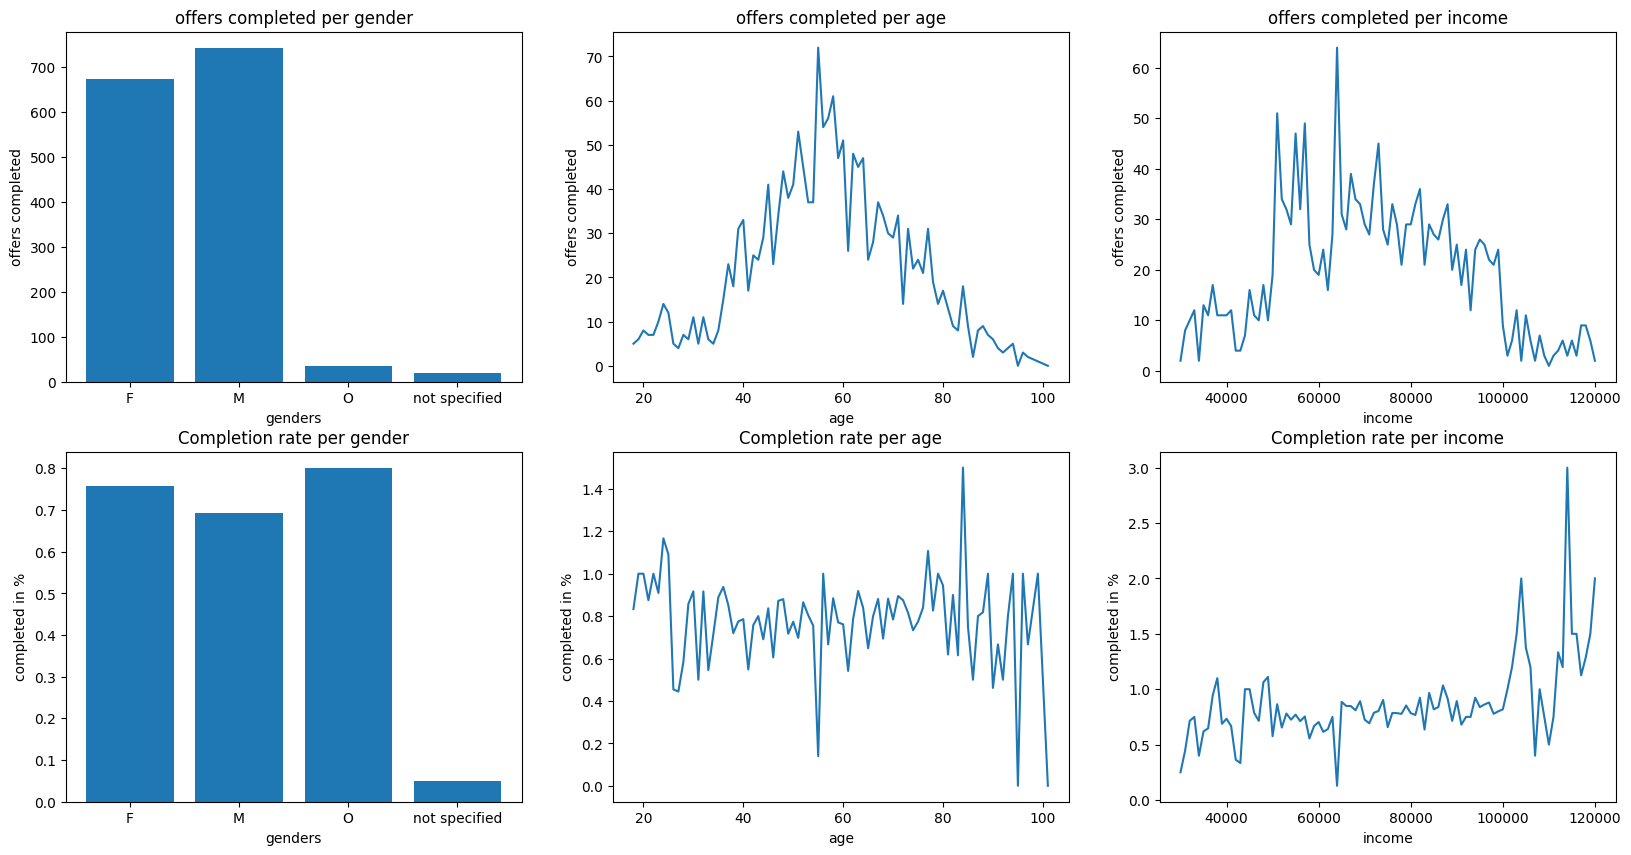

In [ ]:
#look at genders, age and income for every order id with completion
df_1 = df[df["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7"]
df_1_completed = df_completed[df_completed["offer_id"] == "0b1e1539f2cc45b7b9fa7c272da2e1d7"]
genders_completed_1 = [df_1_completed["gender_F"].sum(), df_1_completed["gender_M"].sum(), df_1_completed["gender_O"].sum(), df_1_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_1 = [df_1_completed["gender_F"].sum()/df_1["gender_F"].sum(), df_1_completed["gender_M"].sum()/df_1["gender_M"].sum(), df_1_completed["gender_O"].sum()/df_1["gender_O"].sum(), df_1_completed["gender_not_specified"].sum()/df_1["gender_not_specified"].sum()]

ages_completed_1 = aggregated_df_ages_completed(df_1)
ages_completion_rate_1 = aggregated_df_ages_completed_completion_rate(df_1)
income_completed_1 = aggregated_df_income_completed(df_1)
income_completion_rate_1 = aggregated_df_income_completion_rate(df_1)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_1,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_1['age'], ages_completed_1["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_1["income"], income_completed_1["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_1,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_1["age"], ages_completion_rate_1["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_1["income"], income_completion_rate_1["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')


Offer 1: 
Other genders are the best customers for this offers when it comes to completion rate. However, the number of other genders is quite low.
The effect of increasing completion rate cannot be observed here. However, there is a strong trend when looking at the income. 
Concerning income, the conclusion is a bit more tricky. It also shows completion rates over 100% which means that some customers completed offers more often than they viewed them. This distorts the result. When looking only at the completion rates below one, there is no trend recognizable. 

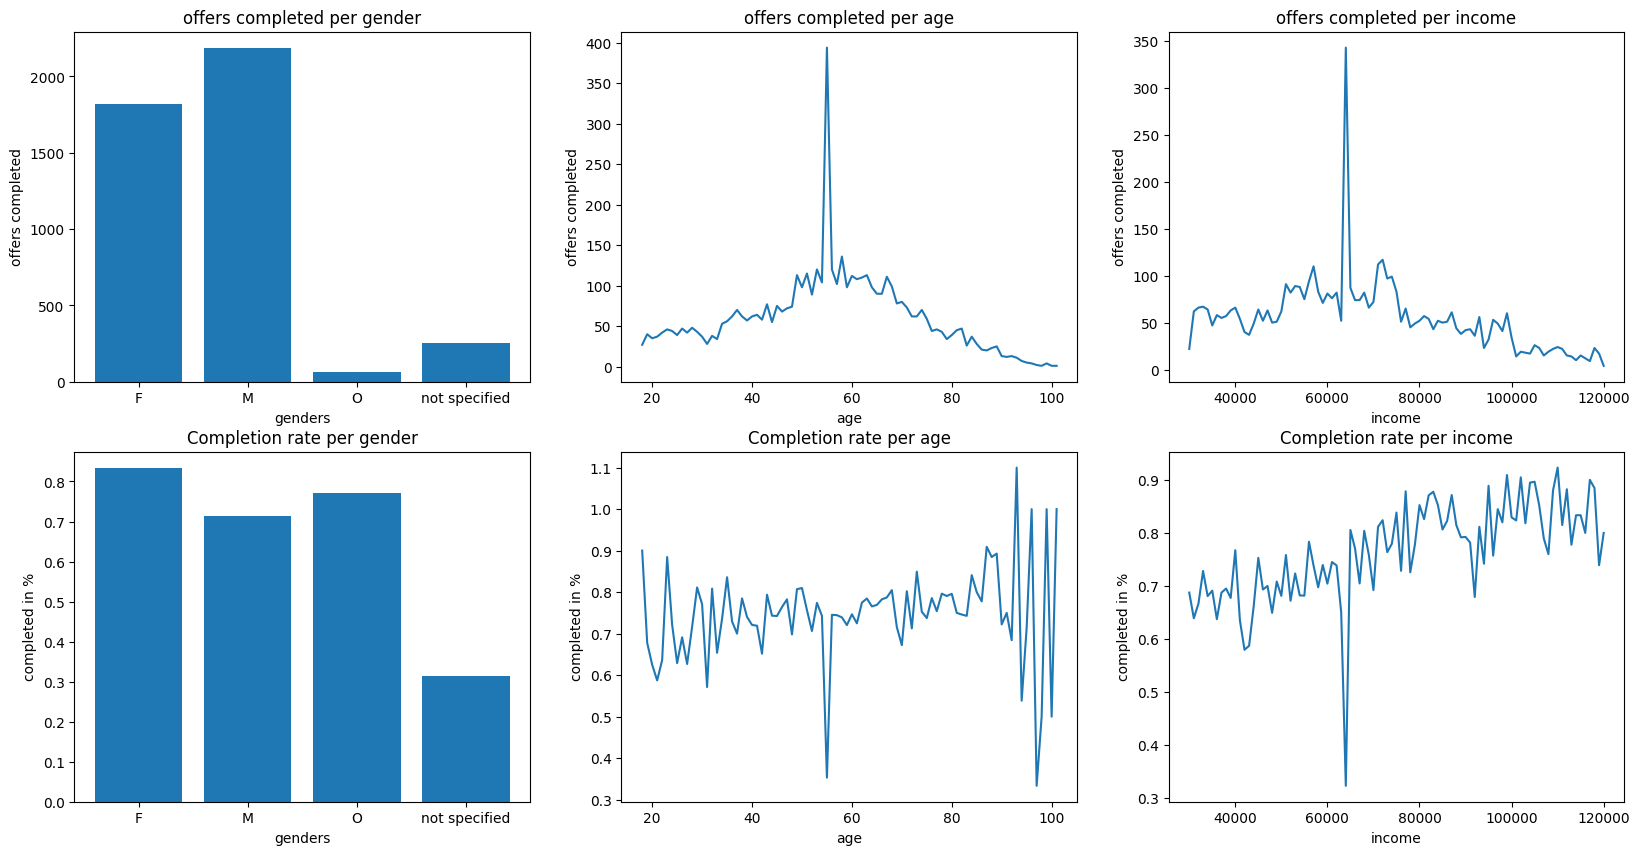

In [ ]:
#look at genders, age and income for every order id with completion
df_2 = df[df["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2"]
df_2_completed = df_completed[df_completed["offer_id"] == "2298d6c36e964ae4a3e7e9706d1fb8c2"]
genders_completed_2 = [df_2_completed["gender_F"].sum(), df_2_completed["gender_M"].sum(), df_2_completed["gender_O"].sum(), df_2_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_2 = [df_2_completed["gender_F"].sum()/df_2["gender_F"].sum(), df_2_completed["gender_M"].sum()/df_2["gender_M"].sum(), df_2_completed["gender_O"].sum()/df_2["gender_O"].sum(), df_2_completed["gender_not_specified"].sum()/df_2["gender_not_specified"].sum()]

ages_completed_2 = aggregated_df_ages_completed(df_2)
ages_completion_rate_2 = aggregated_df_ages_completed_completion_rate(df_2)
income_completed_2 = aggregated_df_income_completed(df_2)
income_completion_rate_2 = aggregated_df_income_completion_rate(df_2)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_2,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_2['age'], ages_completed_2["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_2["income"], income_completed_2["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_2,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_2["age"], ages_completion_rate_2["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_2["income"], income_completion_rate_2["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

Offer 2: 
Female customers are the best customers for this offer when it comes to completion rate.
The effect of increasing completion rate with increasing age cannot be observed here.  
Concerning income, the graphs show an increase of completion rate with increasing income.

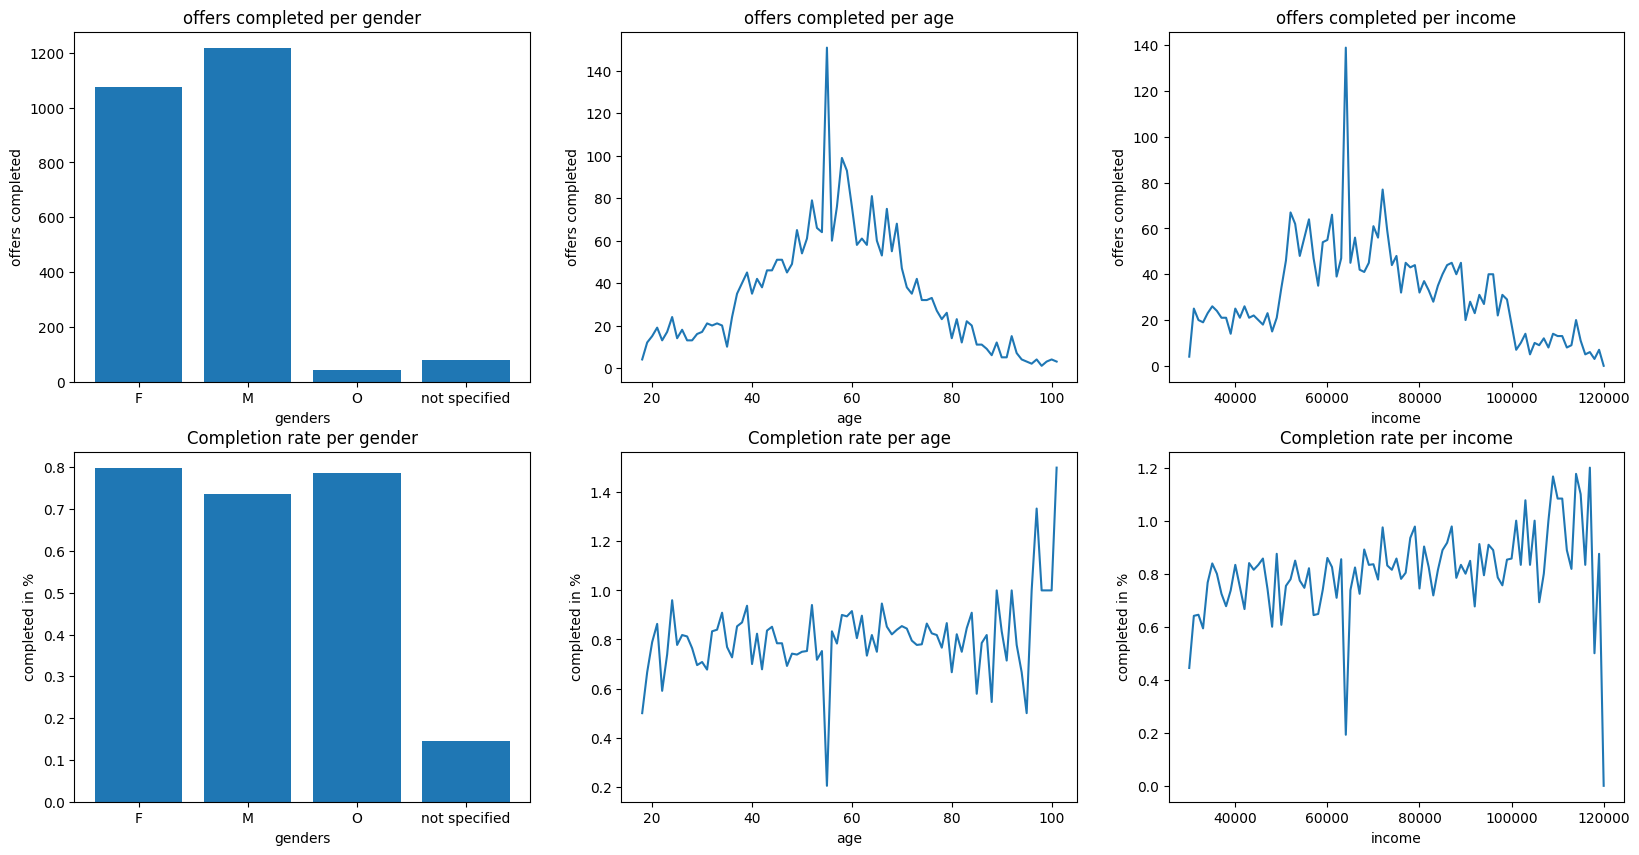

In [ ]:
#look at genders, age and income for every order id with completion
df_3 = df[df["offer_id"] == "2906b810c7d4411798c6938adc9daaa5"]
df_3_completed = df_completed[df_completed["offer_id"] == "2906b810c7d4411798c6938adc9daaa5"]
genders_completed_3 = [df_3_completed["gender_F"].sum(), df_3_completed["gender_M"].sum(), df_3_completed["gender_O"].sum(), df_3_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_3 = [df_3_completed["gender_F"].sum()/df_3["gender_F"].sum(), df_3_completed["gender_M"].sum()/df_3["gender_M"].sum(), df_3_completed["gender_O"].sum()/df_3["gender_O"].sum(), df_3_completed["gender_not_specified"].sum()/df_3["gender_not_specified"].sum()]

ages_completed_3 = aggregated_df_ages_completed(df_3)
ages_completion_rate_3 = aggregated_df_ages_completed_completion_rate(df_3)
income_completed_3 = aggregated_df_income_completed(df_3)
income_completion_rate_3 = aggregated_df_income_completion_rate(df_3)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_3,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_3['age'], ages_completed_3["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_3["income"], income_completed_3["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_3,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_3["age"], ages_completion_rate_3["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_3["income"], income_completion_rate_3["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')


Offer 3: 
Female customers and other genders are the best customers for this offer when it comes to completion rate. However, again other genders have a quite low overall number of completed offers.
The effect of increasing completion rate for increasing age can only be observed for very high ages.
Concerning income, the graphs show a slight increase of completion rate with increasing income.

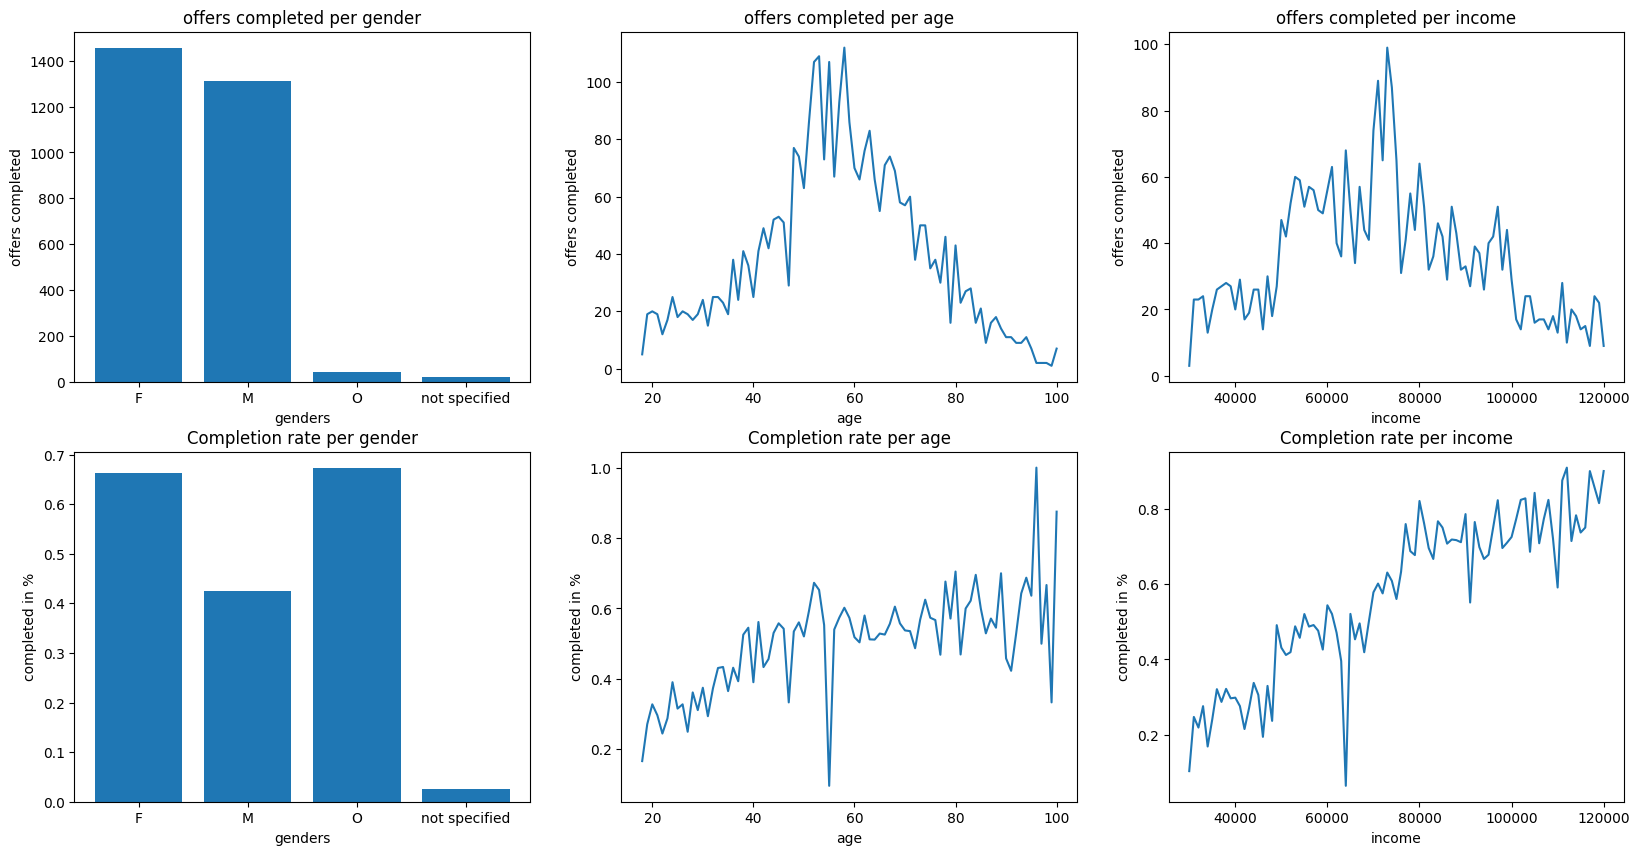

In [ ]:
#look at genders, age and income for every order id with completion
df_4 = df[df["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0"]
df_4_completed = df_completed[df_completed["offer_id"] == "4d5c57ea9a6940dd891ad53e9dbe8da0"]
genders_completed_4 = [df_4_completed["gender_F"].sum(), df_4_completed["gender_M"].sum(), df_4_completed["gender_O"].sum(), df_4_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_4 = [df_4_completed["gender_F"].sum()/df_4["gender_F"].sum(), df_4_completed["gender_M"].sum()/df_4["gender_M"].sum(), df_4_completed["gender_O"].sum()/df_4["gender_O"].sum(), df_4_completed["gender_not_specified"].sum()/df_4["gender_not_specified"].sum()]

ages_completed_4 = aggregated_df_ages_completed(df_4)
ages_completion_rate_4 = aggregated_df_ages_completed_completion_rate(df_4)
income_completed_4 = aggregated_df_income_completed(df_4)
income_completion_rate_4 = aggregated_df_income_completion_rate(df_4)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_4,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_4['age'], ages_completed_4["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_4["income"], income_completed_4["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_4,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_4["age"], ages_completion_rate_4["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_4["income"], income_completion_rate_4["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')



Offer 4: 
Female customers and other genders are the best customers for this offer when it comes to completion rate. Here the difference to mal customers is very high (about 25 percentage points). Again the overall number of other genders is very low.
The effect of increasing completion rate with increasing age and income can be observed here, while the trned is much stronger for income.


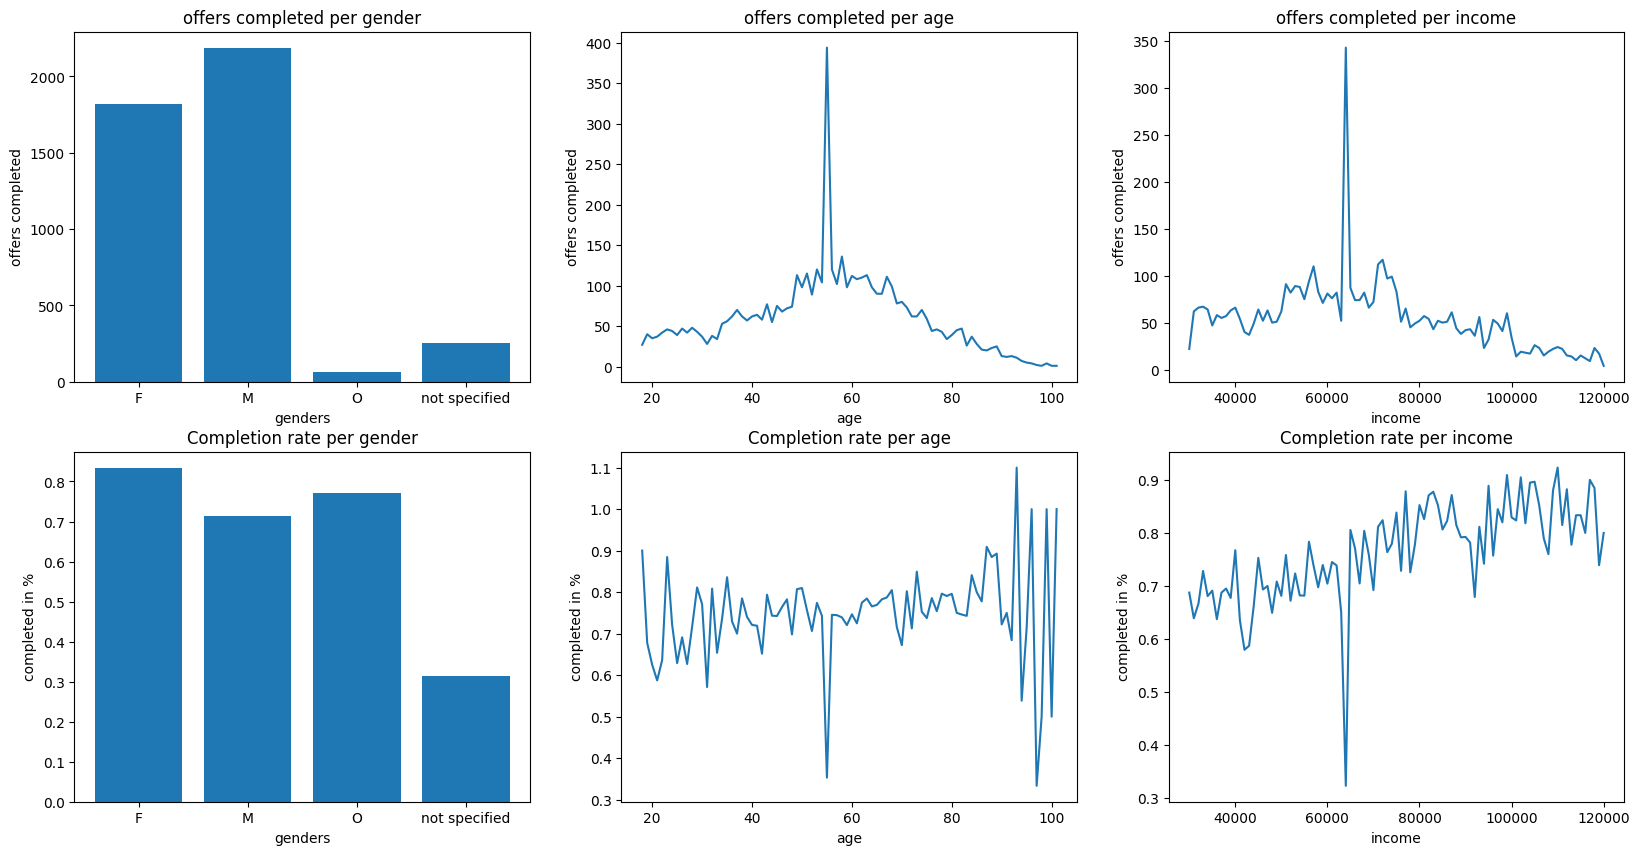

In [ ]:
#look at genders, age and income for every order id with completion
df_5 = df[df["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9"]
df_5_completed = df_completed[df_completed["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9"]
genders_completed_5 = [df_5_completed["gender_F"].sum(), df_5_completed["gender_M"].sum(), df_5_completed["gender_O"].sum(), df_5_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_5 = [df_5_completed["gender_F"].sum()/df_5["gender_F"].sum(), df_5_completed["gender_M"].sum()/df_5["gender_M"].sum(), df_5_completed["gender_O"].sum()/df_5["gender_O"].sum(), df_5_completed["gender_not_specified"].sum()/df_5["gender_not_specified"].sum()]

ages_completed_5 = aggregated_df_ages_completed(df_5)
ages_completion_rate_5 = aggregated_df_ages_completed_completion_rate(df_5)
income_completed_5 = aggregated_df_income_completed(df_5)
income_completion_rate_5 = aggregated_df_income_completion_rate(df_5)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_5,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_5['age'], ages_completed_5["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_5["income"], income_completed_5["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_5,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_5["age"], ages_completion_rate_5["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_5["income"], income_completion_rate_5["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

Offer 5: 
Female customers are the best customers for this offer when it comes to completion rate.
The effect of increasing completion rate with increasing age cannot be observed here.  
Concerning income, the graphs show an increase of completion rate with increasing income.

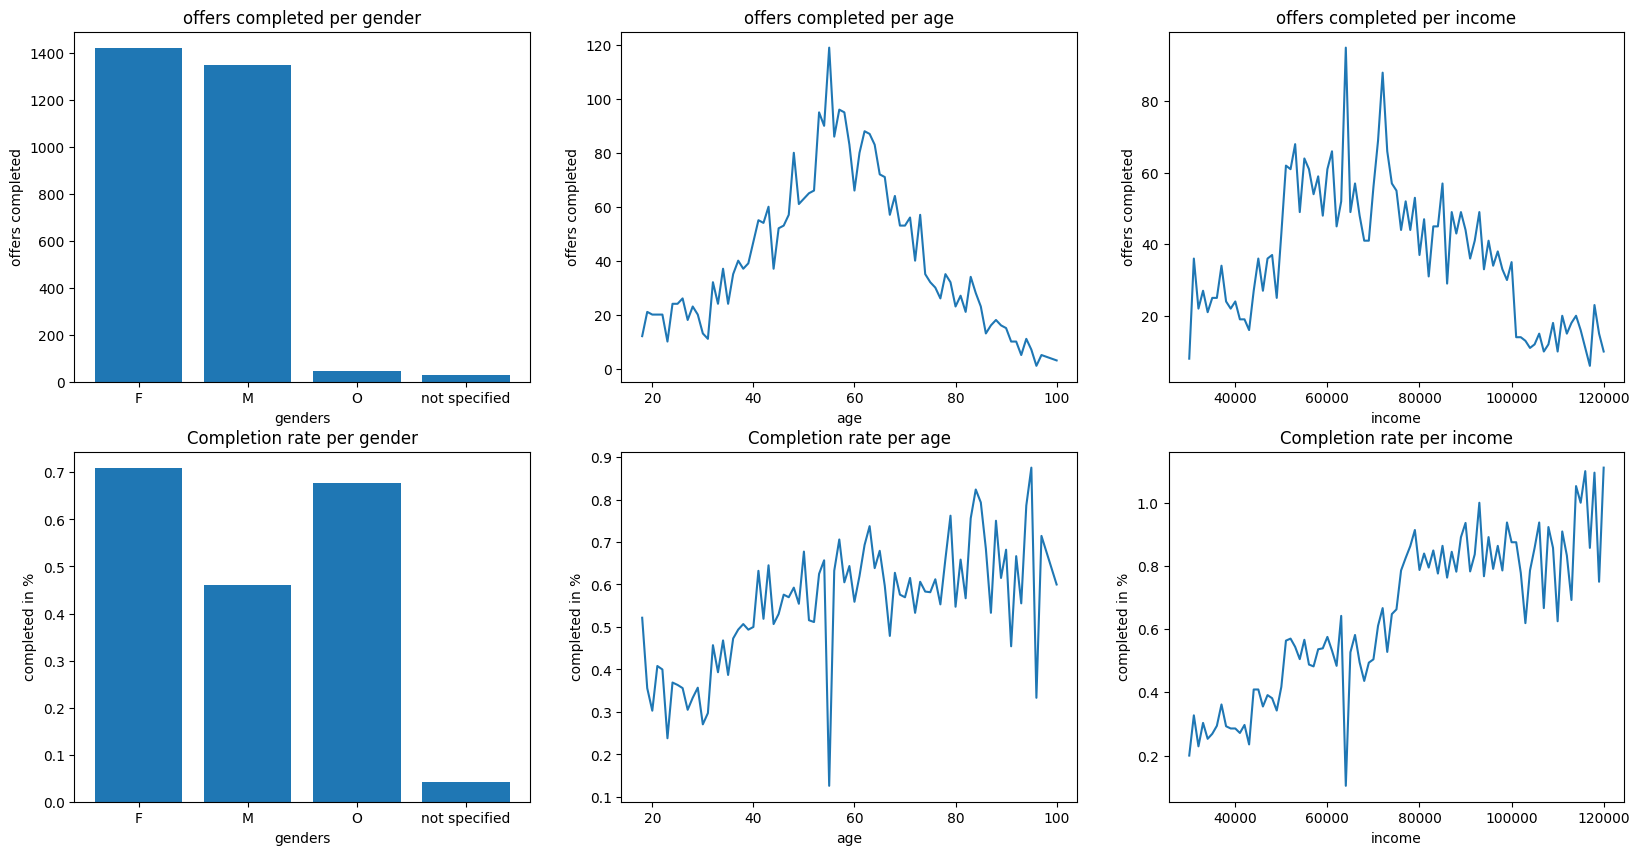

In [ ]:
#look at genders, age and income for every order id with completion
df_6 = df[df["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd"]
df_6_completed = df_completed[df_completed["offer_id"] == "ae264e3637204a6fb9bb56bc8210ddfd"]
genders_completed_6 = [df_6_completed["gender_F"].sum(), df_6_completed["gender_M"].sum(), df_6_completed["gender_O"].sum(), df_6_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_6 = [df_6_completed["gender_F"].sum()/df_6["gender_F"].sum(), df_6_completed["gender_M"].sum()/df_6["gender_M"].sum(), df_6_completed["gender_O"].sum()/df_6["gender_O"].sum(), df_6_completed["gender_not_specified"].sum()/df_6["gender_not_specified"].sum()]

ages_completed_6 = aggregated_df_ages_completed(df_6)
ages_completion_rate_6 = aggregated_df_ages_completed_completion_rate(df_6)
income_completed_6 = aggregated_df_income_completed(df_6)
income_completion_rate_6 = aggregated_df_income_completion_rate(df_6)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_6,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_6['age'], ages_completed_6["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_6["income"], income_completed_6["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_6,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_6["age"], ages_completion_rate_6["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_6["income"], income_completion_rate_6["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

Offer 6:
Female customers and other genders are the best customers for this offer when it comes to completion rate. Here the difference to mal customers is very high (about 25 percentage points). Again the overall number of other genders is very low.
The effect of increasing completion rate with increasing age and income can be observed here, while the trned is much stronger for income.

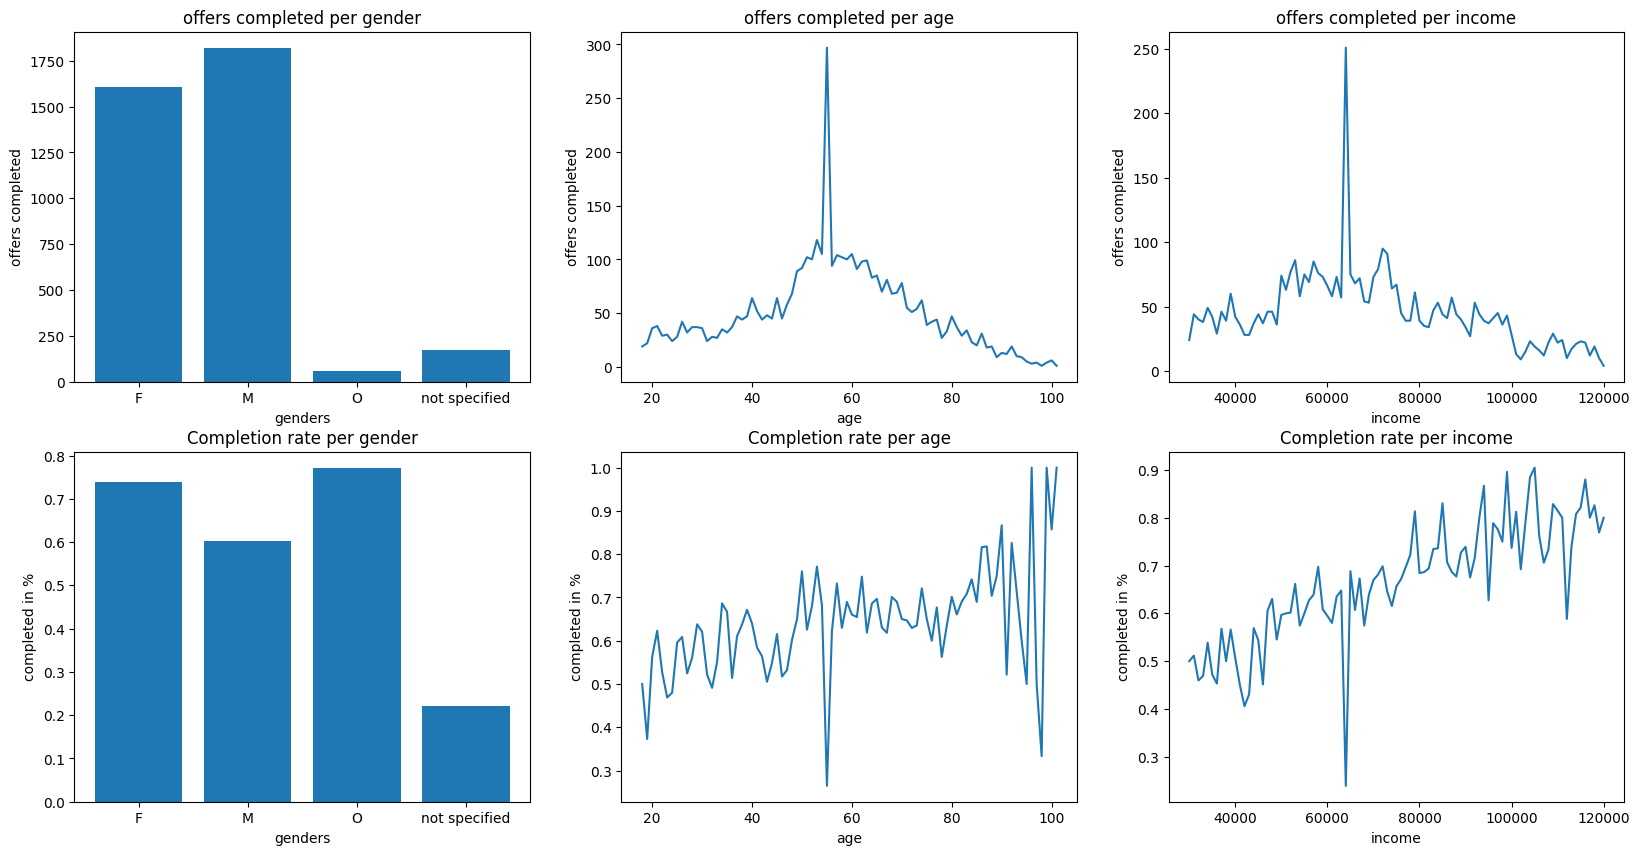

In [ ]:
#look at genders, age and income for every order id with completion
df_7 = df[df["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d"]
df_7_completed = df_completed[df_completed["offer_id"] == "f19421c1d4aa40978ebb69ca19b0e20d"]
genders_completed_7 = [df_7_completed["gender_F"].sum(), df_7_completed["gender_M"].sum(), df_7_completed["gender_O"].sum(), df_7_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_7 = [df_7_completed["gender_F"].sum()/df_7["gender_F"].sum(), df_7_completed["gender_M"].sum()/df_7["gender_M"].sum(), df_7_completed["gender_O"].sum()/df_7["gender_O"].sum(), df_7_completed["gender_not_specified"].sum()/df_7["gender_not_specified"].sum()]

ages_completed_7 = aggregated_df_ages_completed(df_7)
ages_completion_rate_7 = aggregated_df_ages_completed_completion_rate(df_7)
income_completed_7 = aggregated_df_income_completed(df_7)
income_completion_rate_7 = aggregated_df_income_completion_rate(df_7)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_7,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_7['age'], ages_completed_7["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_7["income"], income_completed_7["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_7,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_7["age"], ages_completion_rate_7["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_7["income"], income_completion_rate_7["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

Offer 7:
Female customers and other genders are the best customers for this offer when it comes to completion rate. Here the difference to male customers is relatively high (about 15 percentage points). Again the overall number of other genders is very low.
The effect of increasing completion rate with increasing age and income can be observed here.

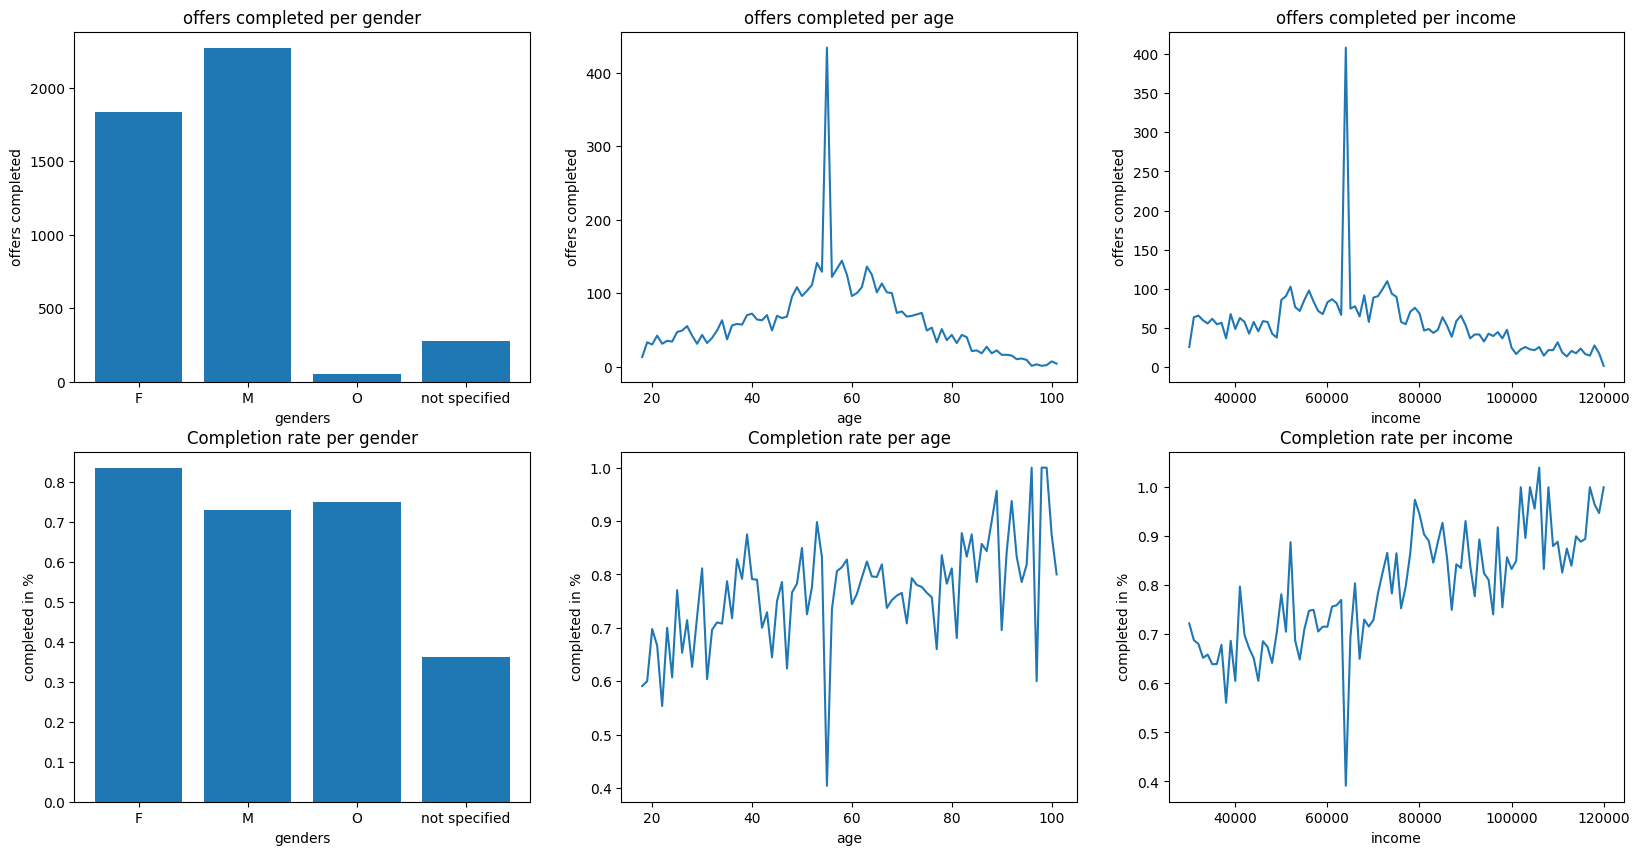

In [ ]:
#look at genders, age and income for every order id with completion
df_8 = df[df["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4"]
df_8_completed = df_completed[df_completed["offer_id"] == "fafdcd668e3743c1bb461111dcafc2a4"]
genders_completed_8 = [df_8_completed["gender_F"].sum(), df_8_completed["gender_M"].sum(), df_8_completed["gender_O"].sum(), df_8_completed["gender_not_specified"].sum().sum()]
genders_completion_rate_8 = [df_8_completed["gender_F"].sum()/df_8["gender_F"].sum(), df_8_completed["gender_M"].sum()/df_8["gender_M"].sum(), df_8_completed["gender_O"].sum()/df_8["gender_O"].sum(), df_8_completed["gender_not_specified"].sum()/df_8["gender_not_specified"].sum()]

ages_completed_8 = aggregated_df_ages_completed(df_8)
ages_completion_rate_8 = aggregated_df_ages_completed_completion_rate(df_8)
income_completed_8 = aggregated_df_income_completed(df_8)
income_completion_rate_8 = aggregated_df_income_completion_rate(df_8)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplot(2, 3, 1)
create_bar_chart(['F','M','O',"not specified"],genders_completed_8,'genders','offers completed','offers completed per gender')
plt.subplot(2, 3, 2)
create_linegraph(ages_completed_8['age'], ages_completed_8["offer_completed"], 'age', 'offers completed', 'offers completed per age')
plt.subplot(2, 3, 3)
create_linegraph(income_completed_8["income"], income_completed_8["offer_completed"], 'income', 'offers completed', 'offers completed per income')
plt.subplot(2, 3, 4)
create_bar_chart(['F','M','O',"not specified"],genders_completion_rate_8,'genders','completed in %','Completion rate per gender')
plt.subplot(2, 3, 5)
create_linegraph(ages_completion_rate_8["age"], ages_completion_rate_8["ages_completion_rate"], 'age', 'completed in %', 'Completion rate per age')
plt.subplot(2, 3, 6)
create_linegraph(income_completion_rate_8["income"], income_completion_rate_8["income_completion_rate"], 'income', 'completed in %', 'Completion rate per income')

Offer 8:
Female customers are the best customers for this offer when it comes to completion rate. 
The effect of increasing completion rate with increasing age and income can be observed here.

## 4. Results